# Identificando perfis de usuários de E-Commerce

Este projeto visa caracterizar diferentes tipos de clientes e produtos da loja online Everything Plus. O conjunto de dados disponibilizado contém o histórico de transações dos usuários na loja, com informações sobre cada pedido. A partir dessas informações vamos realizar uma análise exploratória buscando observar características que permitam organizar os clientes em diferentes grupos. Também vamos observar características dos produtos e dos pedidos na loja.

Para segmentar os clientes, executaremos duas análises: de RFM (Recency, Frequency, Monetary value) e de Lifetime Value (LTV). Para descobrir relações entre produtos faremos uma análise de cesta de compras (Market Basket Analyisis).

Por fim, vamos testar se há uma diferença estatisticamente significante entre os grupos criados a partir das características dos usuários.

## Pré-processamento

Vamos começar esta etapa importando as bibliotecas que usaremos no projeto.

In [1]:
# Bibliotecas para criação e manipulação de tabelas de dados
import pandas as pd
import numpy as np
from datetime import datetime

# Bibliotecas para criação e manipução de gráficos e diagramas
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para operações estatísticas
from scipy import stats as st

# Bibliotecas para calcular frequência de compra e associação entre produtos
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Agora vamos carregar nossos dados, armazenados no arquivo ``ecommerce_dataset_us.csv``, no DataFrame ``ec_dt``.

In [2]:
# Carregando os dados
ec_dt = pd.read_csv('C:/Users/atlas/documents/projetos_dados/datasets/ecommerce_dataset_us.csv', sep='\t')

# Exibindo as primeiras linhas
ec_dt.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


Vamos conferir as informações gerais da tabela.

In [3]:
ec_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


Vemos que há algumas descrições e vários IDs de consumidores em falta. Já os formatos das colunas estão corretos, com a excessão da coluna ``InvoiceDate``, que deveria ser DateTime e está como string. Vamos corrigir o formato.

In [4]:
ec_dt['InvoiceDate'] = pd.to_datetime(ec_dt['InvoiceDate'], format='%m/%d/%Y %H:%M')

Agora vamos procurar linhas duplicadas na tabela.

In [5]:
ec_dt.duplicated().sum()

5268

Na tabela existem 5268 duplicatas óbvias, vamos excluir essas linhas e conferir como ficam nossos dados:

In [6]:
# Excluindo as linhas duplicadas
ec_dt.drop_duplicates(inplace=True)

# Conferindo como ficaram as informações da tabela
ec_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 32.8+ MB


Vamos conferir agora algumas das linhas onde ``Description`` está em branco.

In [7]:
ec_dt[ec_dt['Description'].isnull()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN
1988,536550,85044,NaN,1,2018-11-29 14:34:00,0.0,NaN
2024,536552,20950,NaN,1,2018-11-29 14:34:00,0.0,NaN
2025,536553,37461,NaN,3,2018-11-29 14:35:00,0.0,NaN
2026,536554,84670,NaN,23,2018-11-29 14:35:00,0.0,NaN
2406,536589,21777,NaN,-10,2018-11-29 16:50:00,0.0,NaN


As linhas com valores vazios em ``Description`` parecem ter outro valor em comum: um preço de 0,0. Vamos conferir se todas as linhas com descrições vazias têm preço 0.

In [8]:
ec_dt.loc[(ec_dt['Description'].isnull())]['UnitPrice'].unique()

array([0.])

Podemos confirmar que todas as linhas sem descrição têm preço 0. Mas antes de excluir essas linhas, vamos conferir o que há nas outras linhas com preço 0.

In [9]:
ec_dt.loc[(ec_dt['UnitPrice']==0.0)]['Description'].unique()

array([nan, 'amazon', '?', 'ROUND CAKE TIN VINTAGE GREEN', 'check',
       'damages', 'CREAM SWEETHEART LETTER RACK',
       'ZINC WILLIE WINKIE  CANDLE STICK', 'BOX OF 24 COCKTAIL PARASOLS',
       'DOORMAT ENGLISH ROSE ', 'DOORMAT 3 SMILEY CATS',
       'GREEN REGENCY TEACUP AND SAUCER', 'FRENCH BLUE METAL DOOR SIGN 7',
       'FRENCH BLUE METAL DOOR SIGN 5', 'FRENCH BLUE METAL DOOR SIGN 6',
       'FRENCH BLUE METAL DOOR SIGN 4', 'FRENCH BLUE METAL DOOR SIGN No',
       'FRENCH BLUE METAL DOOR SIGN 8', 'FRENCH BLUE METAL DOOR SIGN 1',
       'RED KITCHEN SCALES', 'IVORY KITCHEN SCALES',
       'SET OF 6 SOLDIER SKITTLES', 'CHILDS GARDEN TROWEL BLUE ',
       'CHILDRENS GARDEN GLOVES BLUE', 'PICNIC BASKET WICKER SMALL',
       'PICNIC BASKET WICKER LARGE', 'EMPIRE UNION JACK TV DINNER TRAY',
       'TV DINNER TRAY VINTAGE PAISLEY', 'SPACEBOY TV DINNER TRAY',
       'TV DINNER TRAY DOLLY GIRL', 'CHILDS GARDEN SPADE BLUE',
       'CHILDS GARDEN RAKE BLUE', 'WATERING CAN PINK BUNNY',
  

Podemos observar que o preço 0 não implica uma descrição vazia, mas existem várias informações irregulares, com valores como "?" ou "missing?". Nesse caso, parece mais interessante excluir todas as linhas onde o preço seja 0. Mas antes, vamos conferir quantas linhas são.

In [10]:
print('Quantidade de linhas com preço 0:', len(ec_dt.loc[(ec_dt['UnitPrice']==0.0)]))

print('Percentual de linhas com preço 0: {0:.2f}%'.format((len(ec_dt.loc[(ec_dt['UnitPrice']==0.0)])/len(ec_dt))*100))

Quantidade de linhas com preço 0: 2510
Percentual de linhas com preço 0: 0.47%


Como existem apenas 0,47% de linhas com preço 0, excluir essas não vai alterar significativamente nossa análise. Porém, mantê-los pode impactar os cálculos dos preços médios e medianos dos produtos. Sendo assim, decidimos excluir todas as linhas onde o preço tem valor 0, o que indiretamente também retirará os produtos com descrição vazia.

In [11]:
# Excluindo as linhas com preço 0,0
ec_dt = ec_dt.loc[~(ec_dt['UnitPrice']==0.0)]

# Conferindo as informações
ec_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534131 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    534131 non-null  object        
 1   StockCode    534131 non-null  object        
 2   Description  534131 non-null  object        
 3   Quantity     534131 non-null  int64         
 4   InvoiceDate  534131 non-null  datetime64[ns]
 5   UnitPrice    534131 non-null  float64       
 6   CustomerID   401564 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 32.6+ MB


Não há mais descrições em branco, como prevemos. Vamos ver se existem outros valores incomuns na coluna de preços, primeiro verificando valores negativos.

In [12]:
ec_dt.loc[(ec_dt['UnitPrice']<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


Temos duas linhas com valores negativos na coluna ``UnitPrice``. É possível que o valor seja na verdade positivo, mas como as duas linhas têm o mesmo preço, parece ter sido um erro do sistema. A descrição também não parece corresponder a um produto real. Sendo assim, vamos excluir essas linhas do nosso DataFrame.

In [13]:
ec_dt = ec_dt.loc[~(ec_dt['UnitPrice']<0)]

Agora precisamos ver as linhas sem ``CustomerID`` informado.

In [14]:
ec_dt.loc[(ec_dt['CustomerID'].isnull())].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2018-11-29 14:32:00,2.51,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2018-11-29 14:32:00,2.51,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,2018-11-29 14:32:00,0.85,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2018-11-29 14:32:00,1.66,NaN
1447,536544,21790,VINTAGE SNAP CARDS,9,2018-11-29 14:32:00,1.66,NaN
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2018-11-29 14:32:00,2.51,NaN
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2018-11-29 14:32:00,0.43,NaN
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2018-11-29 14:32:00,0.43,NaN
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2018-11-29 14:32:00,0.43,NaN
1452,536544,21809,CHRISTMAS HANGING TREE WITH BELL,1,2018-11-29 14:32:00,2.51,NaN


É possível associar a falta de ID ao baixo preço das mercadorias. Vamos ver os preços dos produtos onde o ID do consumidor está vazio.

In [15]:
ec_dt.loc[(ec_dt['CustomerID'].isnull())]['UnitPrice'].value_counts().head(20)

2.46     16081
4.13     14803
1.63     12027
0.83     10989
3.29     10698
5.79      6486
8.29      4606
4.96      4376
1.25      3937
7.46      3073
10.79     2959
2.51      2709
0.42      2500
1.66      2490
4.21      2180
3.36      2112
0.85      2097
16.63     1606
12.46     1464
5.91      1419
Name: UnitPrice, dtype: int64

Existem muitos produtos com preço baixo entre os IDs vazios, mas também existem produtos de valor mais alto. Logo, isso não deve explicar a anomalia. Vamos conferir o número exato de linhas com IDs vazios e o percentual deles no total dos dados.

In [16]:
print('Quantidade de linhas sem IDs de usuário:', len(ec_dt.loc[(ec_dt['CustomerID'].isnull())]))

print('Percentual de linhas sem IDs de usuário: {0:.2f}%'.format((len(ec_dt.loc[(ec_dt['CustomerID']
                                                                                 .isnull())])/len(ec_dt))*100))

Quantidade de linhas sem IDs de usuário: 132565
Percentual de linhas sem IDs de usuário: 24.82%


Quase 25% dos dados não possuem ID de usuário. Isso pode indicar que a loja permite compras sem cadastros de usuário. Devido a alta quantidade de dados e a chance disso ser uma característica do sistema da loja, é mais recomendado mantermos essas linhas da forma como estão. Do mesmo modo que como o campo não é quantitativo, valores ausentes não afetarão diretamente nossos cálculos. Só é importante ter esse fato em mente ao calcular a divisão de eventos por usuários.

Por fim, vamos conferir valores incomuns na coluna com as quantidades.

In [17]:
ec_dt['Quantity'].unique()

array([     6,      8,      2,     32,      3,      4,     24,     12,
           48,     18,     20,     36,     80,     64,     10,    120,
           96,     23,      5,      1,     -1,     50,     40,    100,
          192,    432,    144,    288,    -12,    -24,     16,      9,
          128,     25,     30,     28,      7,     72,    200,    600,
          480,     -6,     14,     -2,     11,     33,     13,     -4,
           -5,     -7,     -3,     70,    252,     60,    216,    384,
           27,     15,     22,     19,     17,     21,     34,     47,
          108,     52,  -9360,     75,    270,     42,    240,     90,
          320,   1824,    204,     69,    -36,   -192,   -144,    160,
         2880,   1400,     39,    -48,    -50,     56,     26,   1440,
           31,     82,     78,     97,     98,     35,     -8,    720,
          -20,    156,    324,     38,     37,     49,     95,     -9,
          -11,     29,     41,    -10,    -72,    402,    378,    150,
      

Podemos ver vários valores negativos. Vamos calcular quantos exatamente.

In [18]:
print('Quantidade de linhas com quantidade negativa:', len(ec_dt.loc[(ec_dt['Quantity']<=0)]))

print('Percentual de linhas com quantidade negativa: {0:.2f}%'.format((len(ec_dt.loc[(ec_dt['Quantity']<=0)])/len(ec_dt))*100))

Quantidade de linhas com quantidade negativa: 9251
Percentual de linhas com quantidade negativa: 1.73%


Diferente do preço, existem várias linhas com quantidade negativa, com diversos valores diferentes. É possível que essas linhas sejam devoluções ou erros do sistema. De qualquer forma, como não podemos consultar o departamento técnica, é recomendável excluir essas linhas, porque seus valores podem distorcer nossa análise.

In [19]:
# Excluindo as linhas com quantidade negativa
ec_dt = ec_dt.loc[~(ec_dt['Quantity']<=0)]

# Conferindo se restam linhas com valores negativos
print('Quantidade de linhas com quantidade negativa:', len(ec_dt.loc[(ec_dt['Quantity']<=0)]))

Quantidade de linhas com quantidade negativa: 0


Excluímos as linhas com produtos de preço 0 e com quantidades negativas. Porém, mantivemos as linhas com o ID do consumidor ausente, uma vez que se trata de uma fatia muito grande dos dados e que esses dados podem ser úteis para análises de produtos. É importante, contudo, manter em mente que pode ser necessário criar uma versão dos dados sem essas linhas, para análises de comportamento do consumidor.

Uma coluna com o valor do pedido será útil na nossa análise. Vamos calcular multiplicando o preço pela quantidade de cada pedido e armazenando o resultado na coluna ``OrderValue``. Criaremos também uma coluna apenas com a data, ``Date``, outra com a hora do dia, ``hour``, uma com o número da semana (``WeekNumber``) e outra com o dia da semana (``Week``). E, por fim, uma com o mês, ``Month``. Esses dados nos serão úteis mais a frente.

In [20]:
# Criando a coluna OrderValue
ec_dt['OrderValue'] = ec_dt['Quantity']*ec_dt['UnitPrice']

# Criando a coluna Date
ec_dt['Date'] = ec_dt['InvoiceDate'].dt.date

# Criando a coluna Week
ec_dt['Week'] = ec_dt['InvoiceDate'].astype('datetime64[W]')

# Criando a coluna Hour
ec_dt['Hour'] = ec_dt['InvoiceDate'].dt.hour

# Criando a coluna Month
ec_dt['Month'] = ec_dt['InvoiceDate'].astype('datetime64[M]')

# Convertendo as colunas Date para o formato DateTime
ec_dt['Date'] = pd.to_datetime(ec_dt['Date'], format='%Y-%m-%d')

# Observando as primeiras linhas da tabela
ec_dt.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,OrderValue,Date,Week,Hour,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30,2018-11-29,2018-11-29,8,2018-11-01
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,8,2018-11-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00,2018-11-29,2018-11-29,8,2018-11-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,8,2018-11-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,8,2018-11-01


## Análise Exploratória de Dados (EDA)

Vamos iniciar agora a exploração dos dados, para entender melhor suas características e distribuição. Primeiro, vamos observar como se distribui a coluna com os preços dos produtos.

In [21]:
ec_dt['UnitPrice'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

Os preços dos produtos variam entre 0,001 e 13541,33, uma variação grande. Isso pode ser observado também no desvio padrão de 36,09. A média e mediana têm, respectivamente, valores de 3,92 e 2,08. Fica visível que há uma assimetria positiva nos preços, ou seja, existem preços com valores muito altos acima da média, mesmo que a maioria dos produtos tenha um preço baixo (75% está abaixo de 4,13). Vamos ver como os preços dos pedidos se distribuem.

In [22]:
ec_dt.groupby('InvoiceNo').agg({'OrderValue':'sum'}).describe()

,OrderValue
count,19960.000000
mean,533.171884
std,1780.412288
min,0.380000
25%,151.695000
50%,303.300000
75%,493.462500
max,168469.600000


Há também uma grande variação no valor dos pedidos: o pedido mínimo custou 0,38 e o máximo custou 168469,60. A média é de 533,17, porém o desvio padrão de 1780,41 (mais de 3 vezes maior que média) aponta que esse valor pode não ser o mais representativo do conjunto de dados. A mediana, por sua vez, é 303,30. 75% das compras custaram menos de 493,46. Assim, a mediana parece ser um valor mais representativo desta distribuição.

Vamos criar um histograma e um diagrama de caixa para visualizar melhor a distribuição dos preços por pedido. No histograma, vamos adicionar uma linha vertical na altura da mediana.

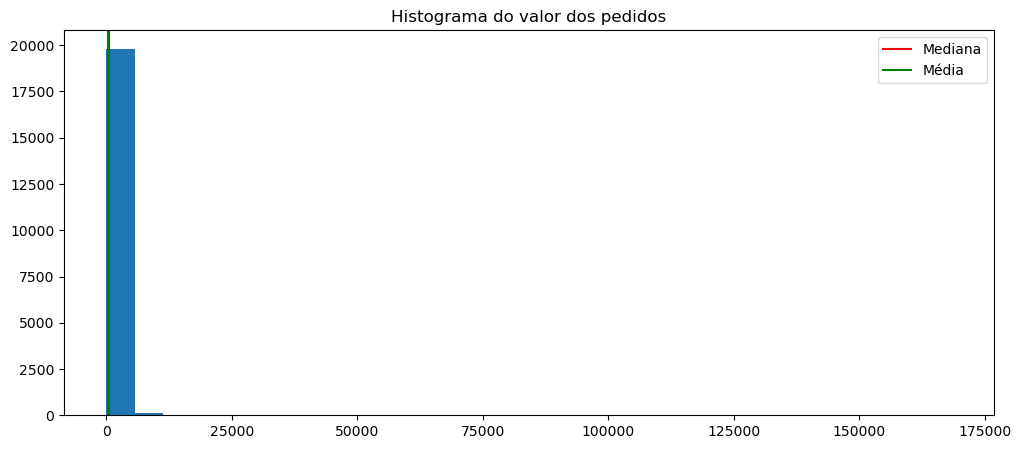

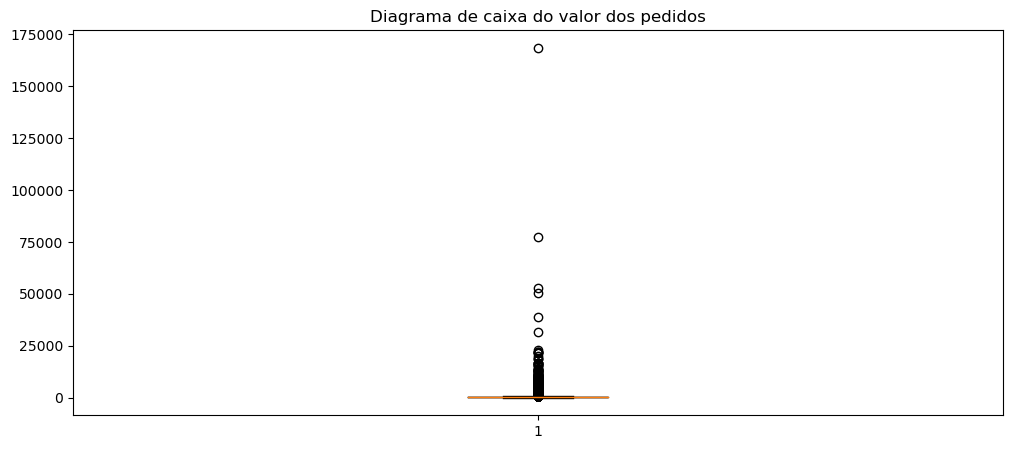

In [23]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt.groupby('InvoiceNo').agg({'OrderValue':'sum'}), bins=30)
plt.axvline(x = 303.3, color = 'r', label = 'Mediana')
plt.axvline(x = 533.18, color = 'g', label = 'Média')
plt.title('Histograma do valor dos pedidos')
plt.legend()
plt.show()

# Criando o diagrama de caixa
plt.figure(figsize=(12,5))
plt.boxplot(ec_dt.groupby('InvoiceNo').agg({'OrderValue':'sum'}))
plt.title('Diagrama de caixa do valor dos pedidos')
plt.show()

Os pedidos custando mais de 5000 distorcem a distribuição de modo que se torna difícil observar o formato. Podemos ver isso também através do diagrama de caixa, que possui uma quantidade grande pontos acima do limite superior. Vamos filtrar a distribuição para valores abaixo de 5000.

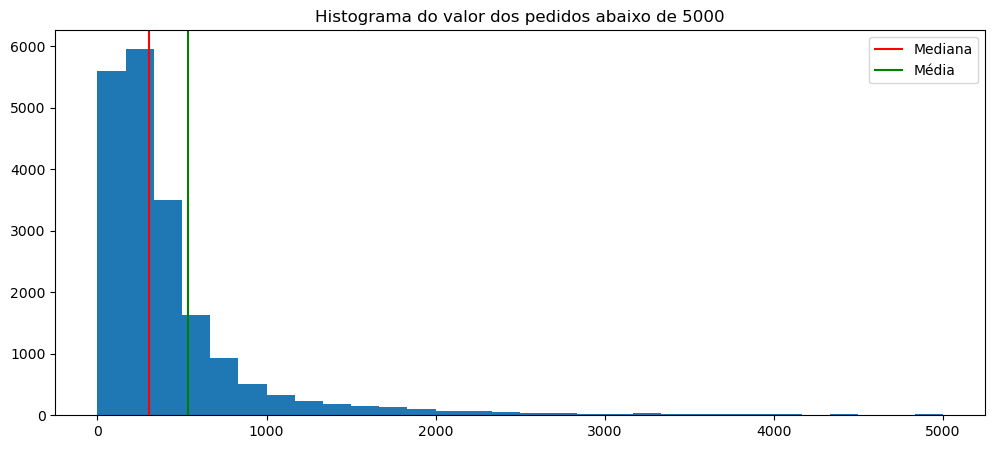

In [24]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt.groupby('InvoiceNo').agg({'OrderValue':'sum'}), range=[0, 5000], bins=30)
plt.axvline(x = 303.3, color = 'r', label = 'Mediana')
plt.axvline(x = 533.18, color = 'g', label = 'Média')
plt.title('Histograma do valor dos pedidos abaixo de 5000')
plt.legend()
plt.show()

O histograma é descrescente, com uma queda expressiva acima de 500. Isso aponta o que a mediana já indicava: que a maioria dos pedidos tem valor entre 0 e 500, mas que existem valores atípicos muito altos distorcendo a média de preço dos pedidos.

Vejamos como o gasto por consumidor varia. Antes disso, vamos filtrar nossos dados para retirar os pedidos onde o ID do consumidor está em branco.

In [25]:
# Filtrando os dados
ec_dt_ = ec_dt.loc[(~ec_dt['CustomerID'].isna())]

# Observando os detalhes dos gastos por usuário
ec_dt_.groupby('CustomerID').agg({'OrderValue':'sum'}).describe()

,OrderValue
count,4338.000000
mean,2048.688081
std,8985.230220
min,3.750000
25%,306.482500
50%,668.570000
75%,1660.597500
max,280206.020000


Os valores de gasto por consumir também tem grande variação, o desvio padrão, por exemplo, é de 8985,23, mais de 4 vezes o valor da média, 2048,69. A mediana é de 668,57 e temos apenas 25% dos consumidores gastando mais que 1660,60. O consumidor que mais gastou, porém, chegou a 280206,02, enquanto o que menos consumiu, somou apenas 3,75. Vamos ver esses dados em um histograma e um diagrama de caixa.

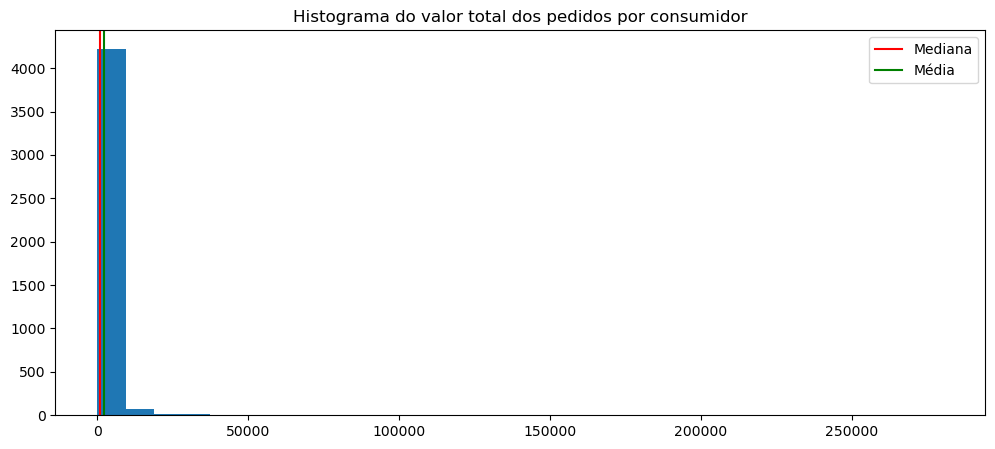

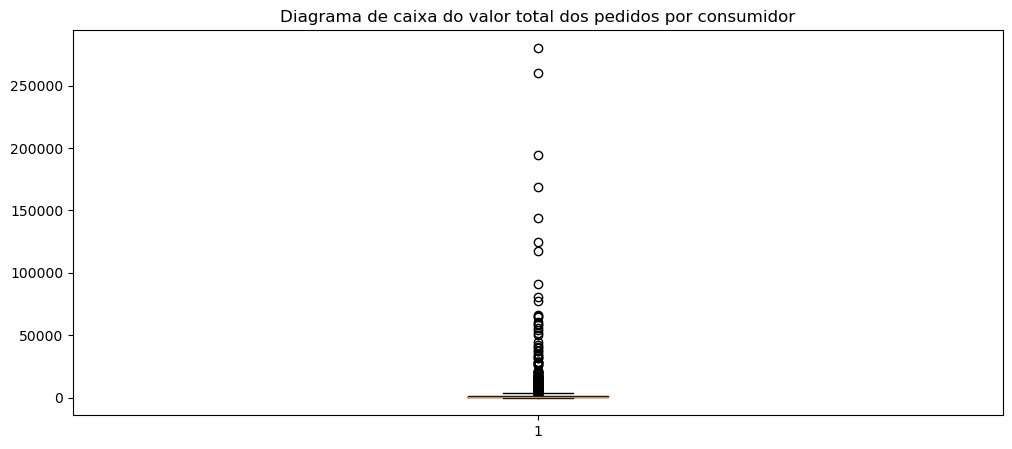

In [26]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'OrderValue':'sum'}), bins=30)
plt.axvline(x = 668.57, color = 'r', label = 'Mediana')
plt.axvline(x = 2048.69, color = 'g', label = 'Média')
plt.title('Histograma do valor total dos pedidos por consumidor')
plt.legend()
plt.show()

# Criando o diagrama de caixa
plt.figure(figsize=(12,5))
plt.boxplot(ec_dt_.groupby('CustomerID').agg({'OrderValue':'sum'}))
plt.title('Diagrama de caixa do valor total dos pedidos por consumidor')
plt.show()

Temos uma situação similar ao valor dos pedidos: valores muito acima do limite superior. Vamos criar um histograma excluindo os valores acima de 10000, que parece corresponder a primeira coluna do histograma.

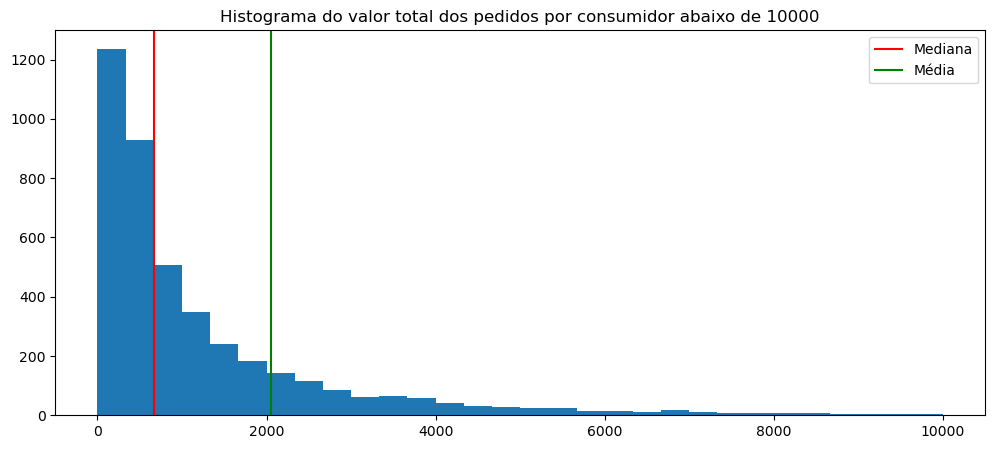

In [27]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'OrderValue':'sum'}), bins=30, range=[0, 10000])
plt.axvline(x = 668.57, color = 'r', label = 'Mediana')
plt.axvline(x = 2048.69, color = 'g', label = 'Média')
plt.title('Histograma do valor total dos pedidos por consumidor abaixo de 10000')
plt.legend()
plt.show()

Agora é visível que a grande maioria dos consumidores gasta menos de 2000. O pico da distribuição se dá entre 0 e 500. É possível afirmar que os consumidores que gastam pouco consumiram menos de 300 (aproximadamente 25% da distribuição), os que tiveram gastos medianos ficaram entre 300 e 1600 (grupo entre o primeiro e o terceiro quartil), e o que os maiores consumidores ficam acima desse valor.

Vamos analisar agora a quantidade por pedido.

In [28]:
ec_dt.groupby('InvoiceNo').agg({'Quantity':'sum'}).describe()

,Quantity
count,19960.000000
mean,279.179359
std,955.011810
min,1.000000
25%,69.000000
50%,150.000000
75%,296.000000
max,80995.000000


A quantidade tem uma variação grande: de 1 a 80995. A média é de 279,18 e o desvio padrão de 955,01. A mediana é 150, os primeiro e terceiro quartil são, respectivamente, 69 e 296. Vamos ver esses valores em um histograma e um diagrama de caixa.

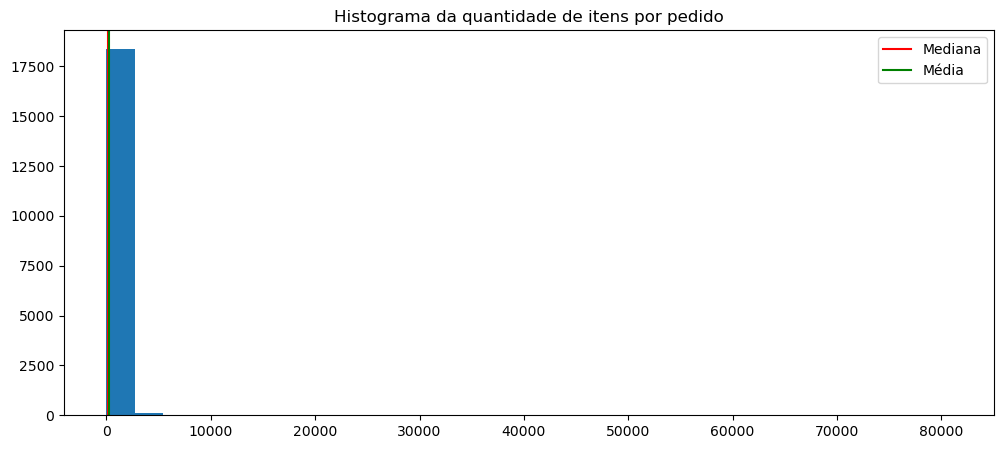

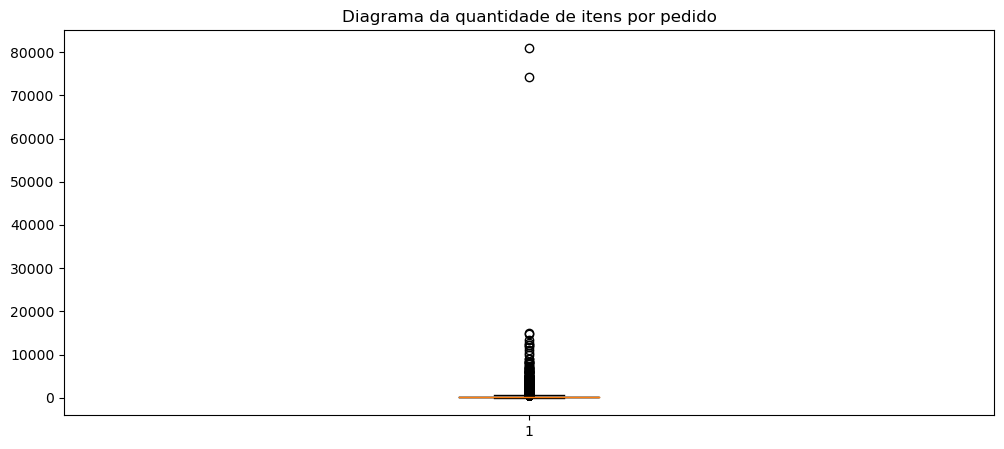

In [29]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('InvoiceNo').agg({'Quantity':'sum'}), bins=30)
plt.axvline(x = 150, color = 'r', label = 'Mediana')
plt.axvline(x = 279.18, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de itens por pedido')
plt.legend()
plt.show()

# Criando o diagrama de caixa
plt.figure(figsize=(12,5))
plt.boxplot(ec_dt_.groupby('InvoiceNo').agg({'Quantity':'sum'}))
plt.title('Diagrama da quantidade de itens por pedido')
plt.show()

Os pedidos se concentram abaixo de 2000 itens. Vamos excluir pedidos acima desse valor e ver como fica nosso histograma.

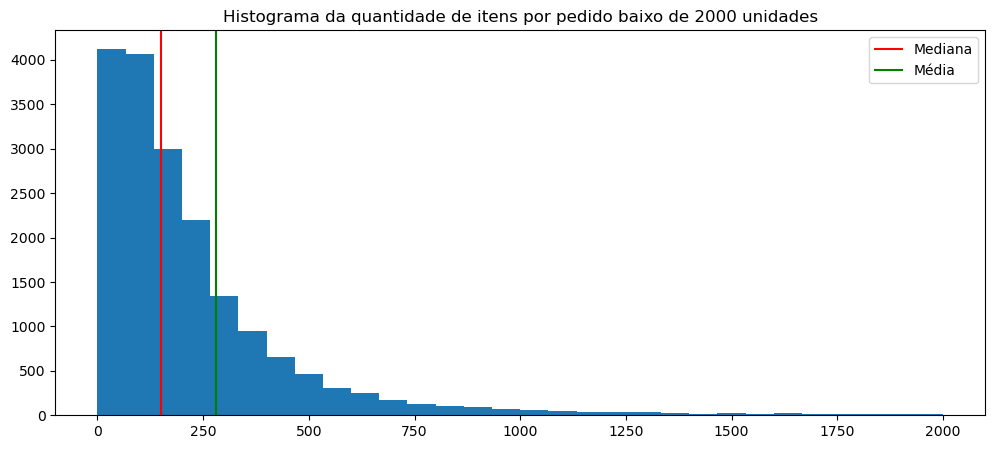

In [30]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('InvoiceNo').agg({'Quantity':'sum'}), bins=30, range=[0, 2000])
plt.axvline(x = 150, color = 'r', label = 'Mediana')
plt.axvline(x = 279.18, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de itens por pedido baixo de 2000 unidades')
plt.legend()
plt.show()

A maioria dos pedidos tem menos de 250 itens, com um pico da distribuição ocorrendo entre 0 e 160 unidades, como apontava nosso cálculos anteriores.

Vejamos agora as informações da quantidade por consumidor, agora utilizando nosso DataFrame sem as linhas com ID de consumidor vazias, ``ec_dt_``.

In [31]:
ec_dt_.groupby('CustomerID').agg({'Quantity':'sum'}).describe()

,Quantity
count,4338.000000
mean,1187.644537
std,5043.619654
min,1.000000
25%,159.000000
50%,378.000000
75%,989.750000
max,196915.000000


Agora temos uma média de 1187,64 e um desvio padrão de 5043,62. Novamente, a mediana, 378, parece ser o valor mais representativo da distribuição dado essas informações. 25% dos consumidores compraram menos de 159 unidades, e apenas 25% compraram mais que 989,75. Porém, o valor máximo ainda foi de 196915. Como todos os dados analisados até agora, a presença de valores incomuns parece acontecer também neste caso. Vamos ver esses valores representados em um diagrama de caixa e um histograma.

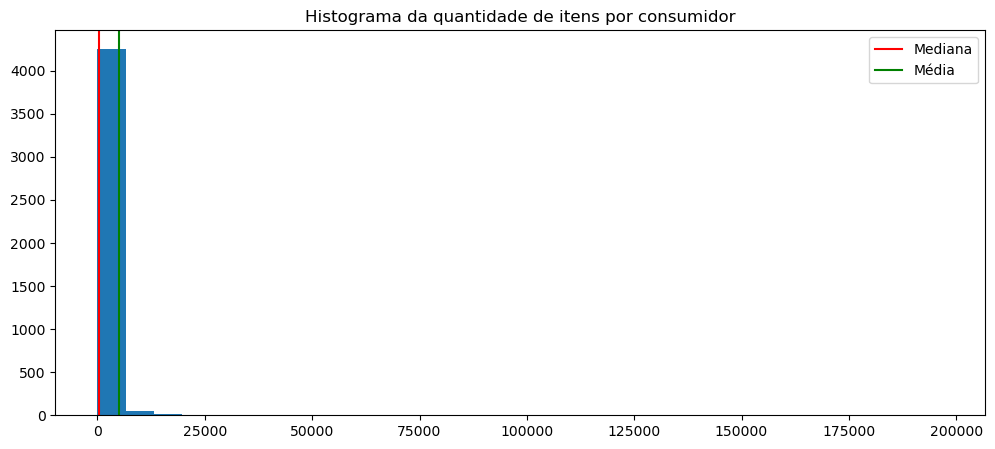

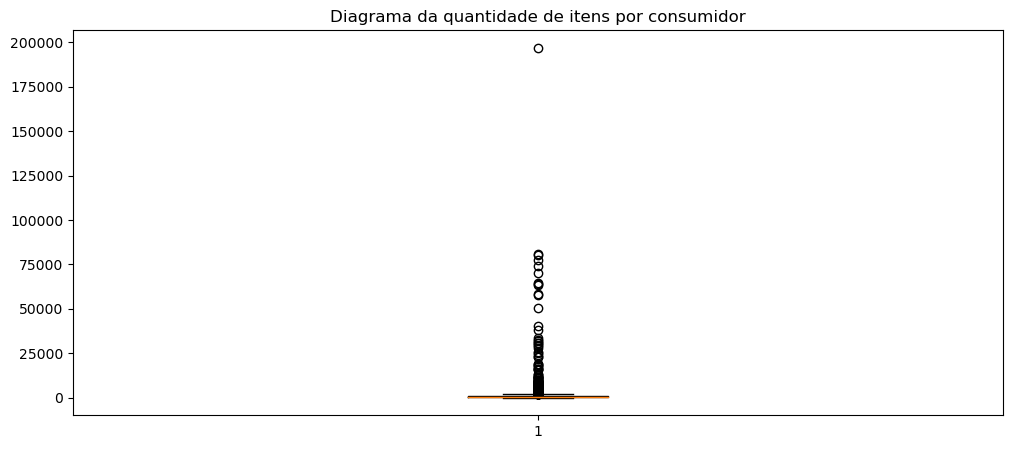

In [32]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'Quantity':'sum'}), bins=30)
plt.axvline(x = 378, color = 'r', label = 'Mediana')
plt.axvline(x = 5043.62, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de itens por consumidor')
plt.legend()
plt.show()

# Criando o diagrama de caixa
plt.figure(figsize=(12,5))
plt.boxplot(ec_dt_.groupby('CustomerID').agg({'Quantity':'sum'}))
plt.title('Diagrama da quantidade de itens por consumidor')
plt.show()

Na primeira coluna do histograma, que se encerra em cerca de 6000 itens, possui quase todos os valores. O formato é confirmado pelo diagrama de caixa, com muitos pontos acima do limite superior. Vamos filtrar o histograma para observar melhor a distribuição.

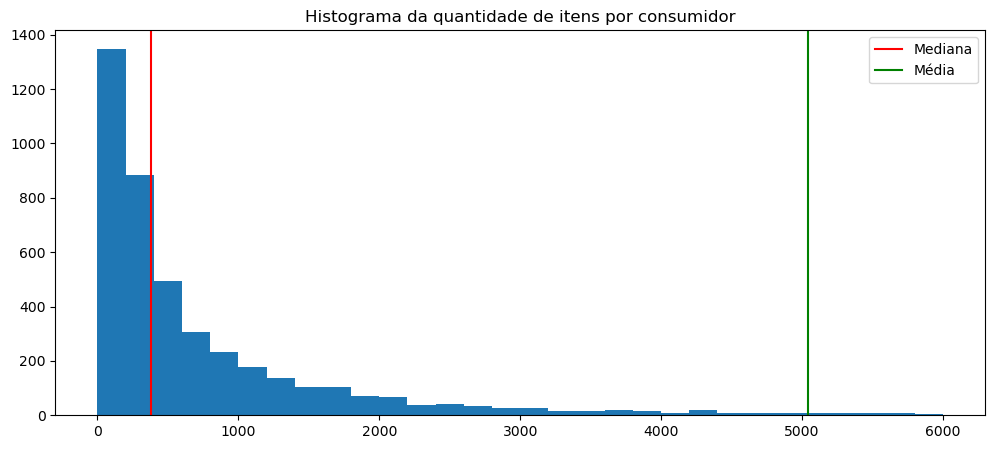

In [33]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'Quantity':'sum'}), bins=30, range=[0, 6000])
plt.axvline(x = 378, color = 'r', label = 'Mediana')
plt.axvline(x = 5043.62, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de itens por consumidor')
plt.legend()
plt.show()

A maioria dos consumidores comprou menos de 1000 itens, com o pico da distribuição se situando abaixo de 200. Os valores dos quartis parecem também ser representativos do comportamento do consumidor nesse caso: é possível considerar consumidores menos assíduos com base nos que consumiram menos de 159, os consumidores medianos entre 159 e 989 itens, e os grandes consumidores acima de 989.

Agora, vamos ver a quantidade de pedidos por usuário, utilizando nossa tabela sem os IDs de consumidor faltosos.



In [34]:
ec_dt_.groupby('CustomerID').agg({'InvoiceNo':'nunique'}).describe()

,InvoiceNo
count,4338.000000
mean,4.272015
std,7.697998
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,209.000000


Com média de 4,27 e mediana de 2, temos agora uma assimetria negativa nos dados. Assim como temos que apenas 25% dos consumidores fizeram mais que 5 pedidos, um número bem próxima da média. Vamos ver esses dados em um histograma:

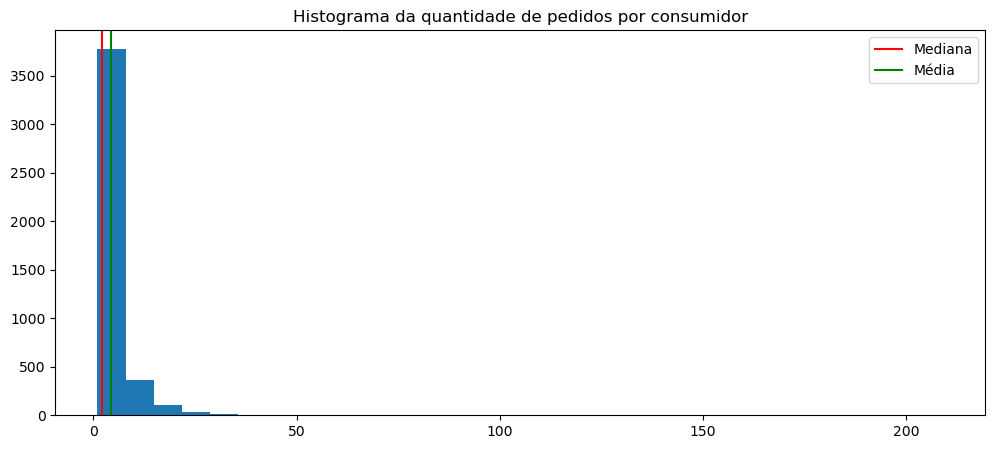

In [35]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'InvoiceNo':'nunique'}), bins=30)
plt.axvline(x = 2, color = 'r', label = 'Mediana')
plt.axvline(x = 4.27, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de pedidos por consumidor')
plt.legend()
plt.show()

Vamoas adicionar um filtro em 20 para melhorar a visualização:

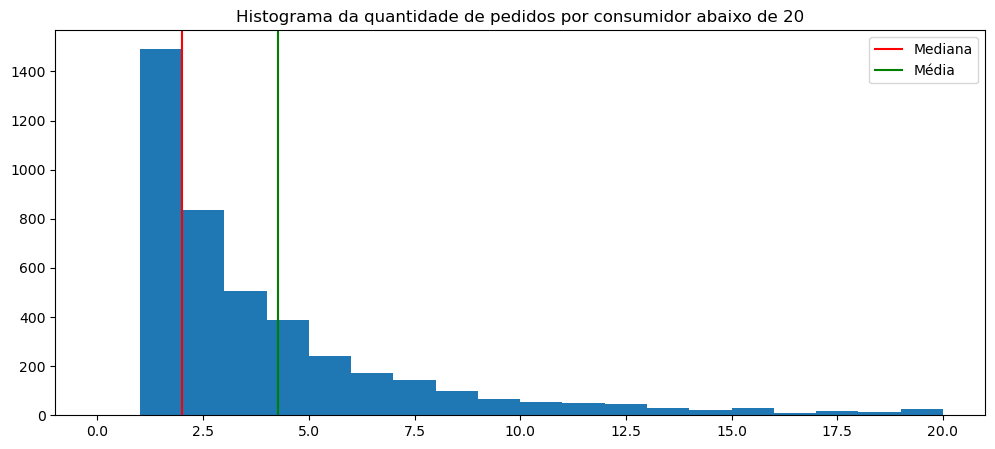

In [36]:
# Criando o histograma
plt.figure(figsize=(12,5))
plt.hist(ec_dt_.groupby('CustomerID').agg({'InvoiceNo':'nunique'}), bins=20, range=[0,20])
plt.axvline(x = 2, color = 'r', label = 'Mediana')
plt.axvline(x = 4.27, color = 'g', label = 'Média')
plt.title('Histograma da quantidade de pedidos por consumidor abaixo de 20')
plt.legend()
plt.show()

Realmente a maioria dos consumidores fez menos de 5 pedidos na loja. A maioria fez menos de 2. Há consumidores que compraram bem mais, mas são pontos isolados na distribuição.

Vamos ver como os pedidos variam por data da compra.

In [37]:
ec_dt.groupby('Date').agg({'InvoiceNo':'nunique'}).describe()

,InvoiceNo
count,305.000000
mean,65.442623
std,25.320397
min,11.000000
25%,49.000000
50%,63.000000
75%,77.000000
max,142.000000


Temos uma média de 65,44 pedidos por dia, com desvio padrão de 25,32. A mediana é 63, bem próxima da média, o que indica uma distribuição mais simétrica que as anteriores. O dia com menos pedidos teve 11 e o com mais pedidos teve 142. 75% dos 305 dias no nosso DataFrame tiveram menos que 77 pedidos.

Vamos conferir por qual período de tempo nossos dados cobrem.

In [38]:
ec_dt['Date'].describe(datetime_is_numeric=True)

count                           524878
mean     2019-07-02 01:55:49.326891008
min                2018-11-29 00:00:00
25%                2019-03-26 00:00:00
50%                2019-07-18 00:00:00
75%                2019-10-17 00:00:00
max                2019-12-07 00:00:00
Name: Date, dtype: object

O primeiro dia da tabela é 29/11/2018 e o último é 07/12/2019. Vamos construir um gráfico de barras com o número de pedidos por data para observar como a quantidade de compras varia no decorrer do ano.

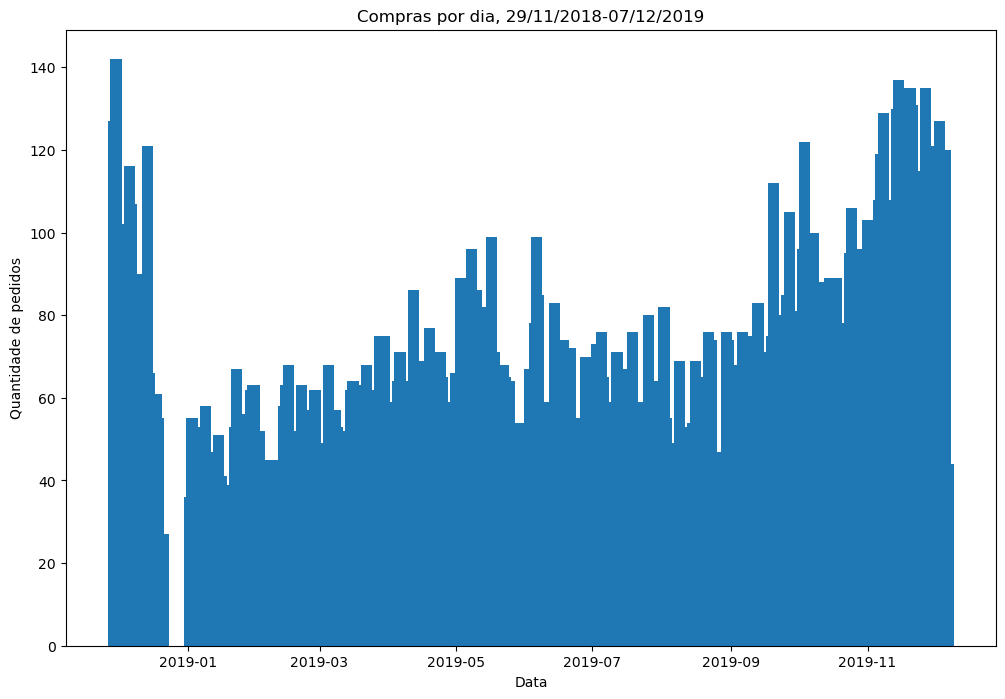

In [39]:
# Criando uma tabela com as informações do número de compras por dia
date_orders = ec_dt.groupby('Date', as_index=False).agg({'InvoiceNo':'nunique'})

# Renomeando a tabela
date_orders.columns = ['Date', 'Orders']

# Criando o gráfico, nomeando e exibindo
plt.figure(figsize=(12,8))
plt.bar(x=date_orders['Date'], height=date_orders['Orders'], width=5)
plt.title('Compras por dia, 29/11/2018-07/12/2019')
plt.ylabel('Quantidade de pedidos')
plt.xlabel('Data')
plt.show()

É possível observar que existiramm períodos com mais e menos vendas, com um crescimento significativo em direção ao fim do ano. Isso pode significar que esse período é mais favorável a loja, ou apenas o crescimento dos pedidos com o passar do tempo; apesar disso também ser notável nos primeiros dias da tabela, que se iniciam em novembro de 2018, é impossível afirmar qual dos dois motivos é mais provável. Para isso seria necessário pelo menos dados para um espaço de tempo de, pelo menos, dois anos. Existem alguns períodos sem vendas, provavelmente por alguma instabilidade no sistema. Vamos utilizar as informações das semanas para ver essas informações de outro ângulo.

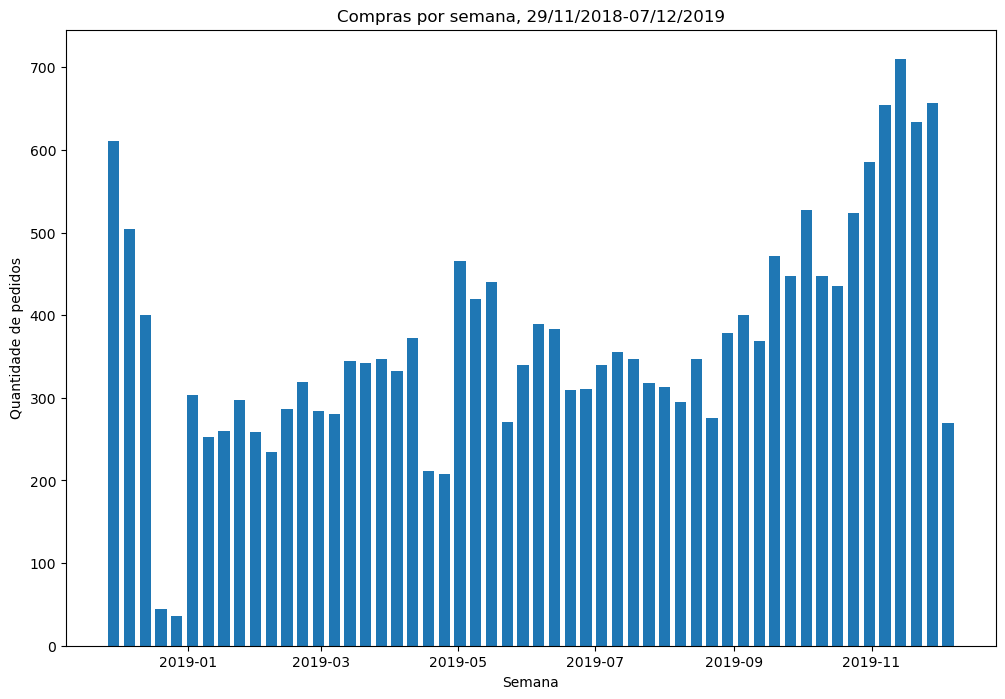

In [40]:
# Criando uma tabela com as informações do número de compras por semana
week_orders = ec_dt.groupby('Week', as_index=False).agg({'InvoiceNo':'nunique'})

# Renomeando a tabela
week_orders.columns = ['Week', 'Orders']

# Criando o gráfico, nomeando e exibindo
plt.figure(figsize=(12,8))
plt.bar(x=week_orders['Week'], height=week_orders['Orders'], width=5)
plt.title('Compras por semana, 29/11/2018-07/12/2019')
plt.ylabel('Quantidade de pedidos')
plt.xlabel('Semana')
plt.show()

Temos um gráfico com menos ruído dessa maneira e podemos confirmar que houve um crescimento significativo das vendas em direção ao fim do ano de 2019. O número de clientes por dia também pode ser importante, vamos calculá-lo.

In [41]:
ec_dt_.groupby('Date').agg({'CustomerID':'nunique'}).describe()

,CustomerID
count,305.000000
mean,54.960656
std,21.447574
min,11.000000
25%,41.000000
50%,52.000000
75%,65.000000
max,125.000000


Em média, a loja teve 54,96 clientes por dia. A mediana ficou em 52 (próxima da média); o primeiro quartil ficou em 41, e o terceiro 65. A distribuição nesse caso parece mais homogênea, apesar de haver um pouco de assimetria negativa. Vamos criar um gráfico de barras para observar a evolução do número de clientes no tempo, por dia e semana.

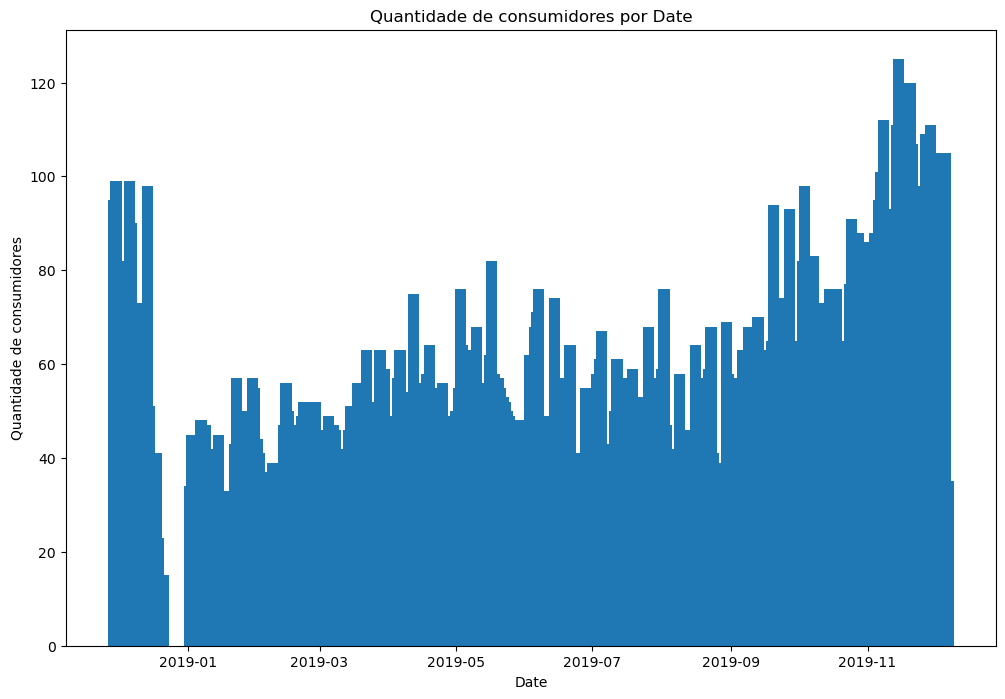

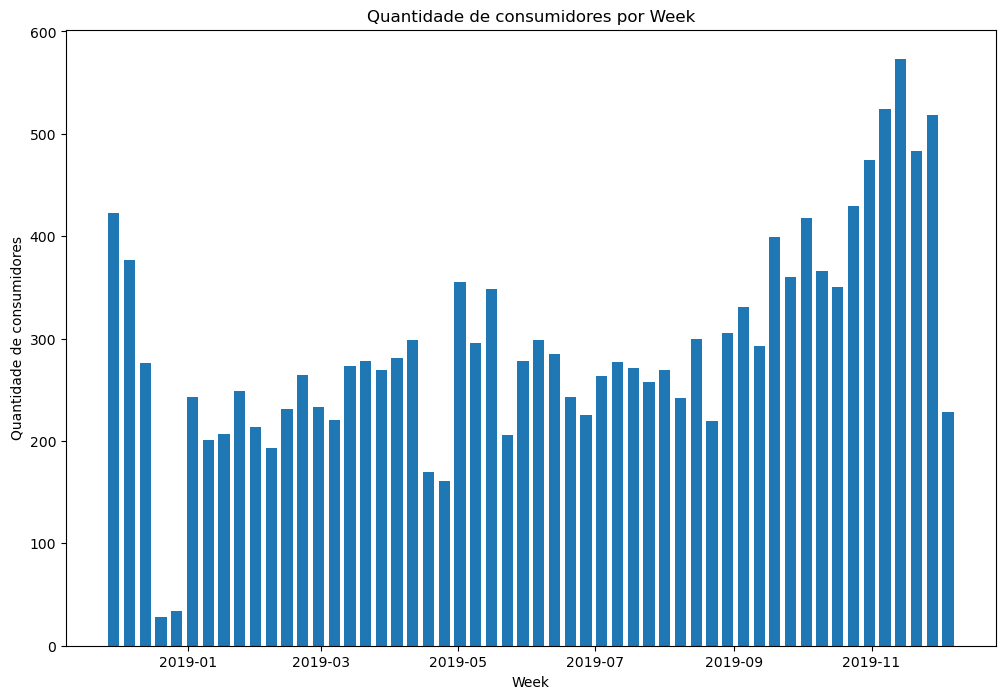

In [42]:
timeframe = ['Date', 'Week']

for time in timeframe:
    df = ec_dt_.groupby(time, as_index=False).agg({'CustomerID':'nunique'})
    df.columns = [time, 'Customers']
    plt.figure(figsize=(12,8))
    plt.bar(x=df[time], height=df['Customers'], width=5)
    plt.title('Quantidade de consumidores por {}'.format(time))
    plt.ylabel('Quantidade de consumidores')
    plt.xlabel(time)
    plt.show()

O número de consumidores tem distribuição ao ano semelhante ao número de pedidos, o que não supreende. Mas indica que os clientes fazem, em média, quantidades de pedidos semelhantes, apesar dos números discrepantes que encontramos em outras variáveis.

Vamos ver também como as receitas diária e semanal se comportam:

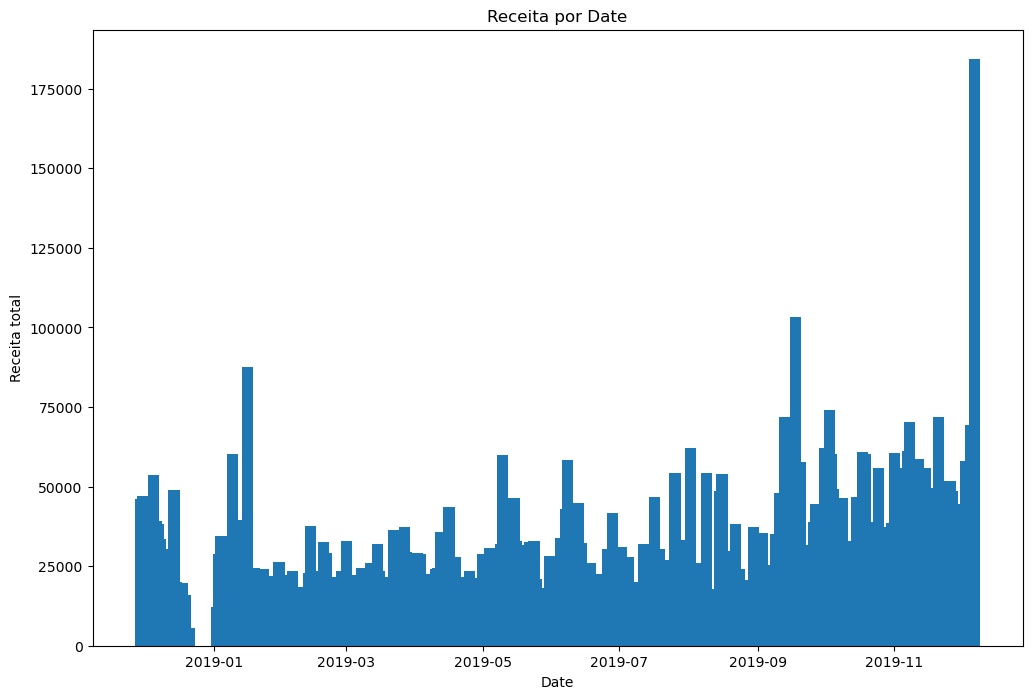

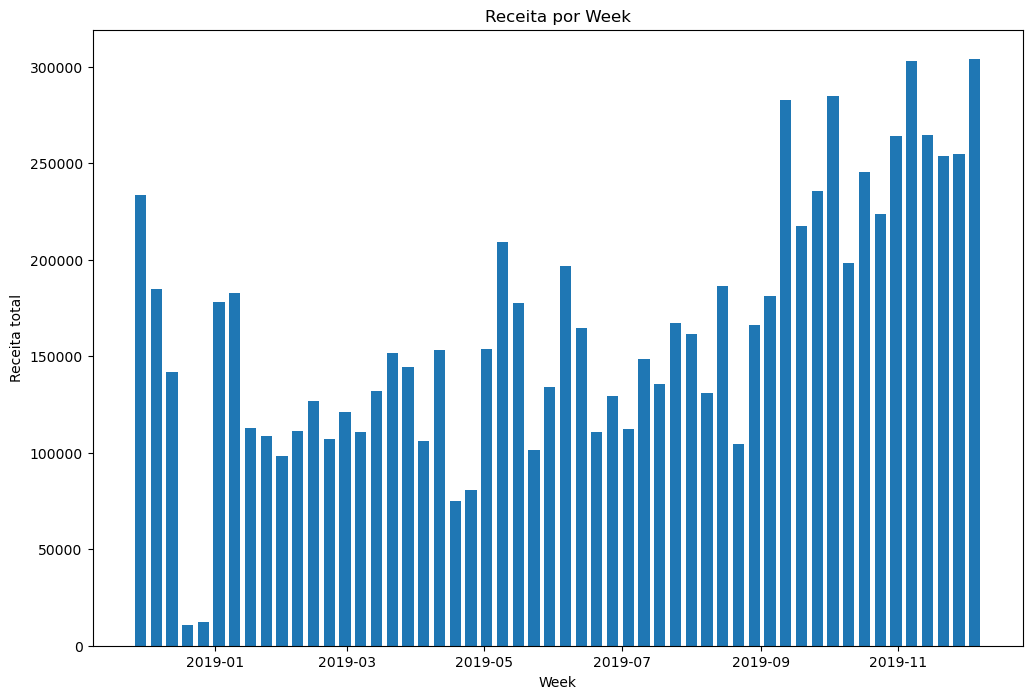

In [43]:
for time in timeframe:
    df = ec_dt_.groupby(time, as_index=False).agg({'OrderValue':'sum'})
    df.columns = [time, 'OrderValue']
    plt.figure(figsize=(12,8))
    plt.bar(x=df[time], height=df['OrderValue'], width=5)
    plt.title('Receita por {}'.format(time))
    plt.ylabel('Receita total')
    plt.xlabel(time)
    plt.show()

Assim como o número de pedidos e o número de consumidores, a receita tende a crescer em direção aos últimos meses do ano. No gráfico diário, podedmos observar que há um dia em especial com um receita bem acima dos outros. Vamos ver qual é esse dia, talvez isso nos ajude a entender o porquê dessa diferença.

In [44]:
ec_dt_.groupby('Date', as_index=False).agg({'OrderValue':'sum'}).sort_values(by='OrderValue', ascending=False).head()

,Date,OrderValue
304,2019-12-07,184329.66
235,2019-09-18,103377.68
32,2019-01-16,87559.21
248,2019-10-03,73975.57
231,2019-09-13,71926.69


O dia 7 de Dezembro de 2019 teve uma receita quase duas vezes maior que o segundo dia com maior receita, 18 de Setembro do mesmo ano. É interessante analisar as ações executadas nesse dia, porque seu resultado foi extremamente positivo para loja.

É interessante observar como os pedidos se distribuem ao longo do dia. Vamos fazer isso criando um gráfico de barras.

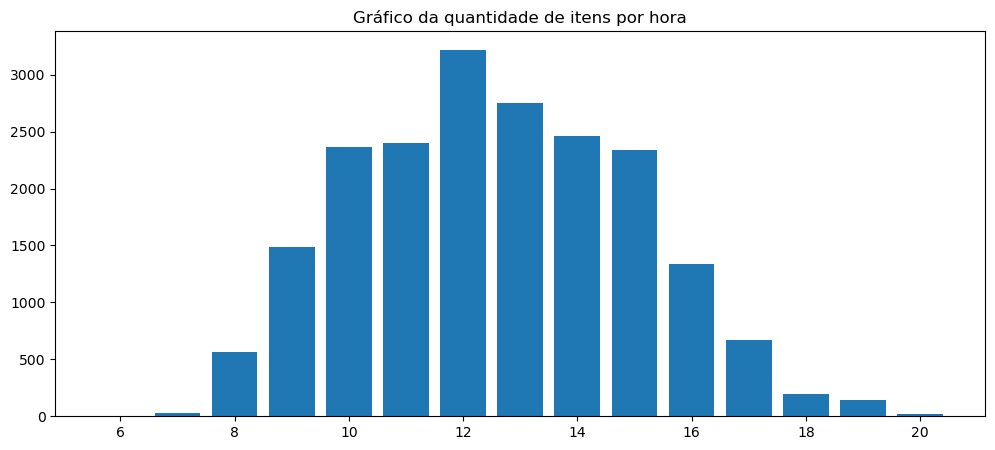

In [45]:
# Criando o gráfico
orders_hour = ec_dt.groupby('Hour', as_index=False).agg({'InvoiceNo':'nunique'})
plt.figure(figsize=(12,5))
plt.bar(x=orders_hour['Hour'], height=orders_hour['InvoiceNo'])
plt.title('Gráfico da quantidade de itens por hora')
plt.show()

A maioria dos pedidos ocorreram entre 9 e 16 horas. Os dados sequer contém qualquer compra ocorrida entre 21 e 5 horas.

Vamos descobrir quais os 10 produtos mais vendidos e visualizar o resultado em um gráfico de barras horizontais.

     StockCode                         Description  Quantity
2668     23843         PAPER CRAFT , LITTLE BIRDIE     80995
2123     23166      MEDIUM CERAMIC TOP STORAGE JAR     78033
3128     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54951
3619    85099B             JUMBO BAG RED RETROSPOT     48371
3640    85123A  WHITE HANGING HEART T-LIGHT HOLDER     37580
1129     22197                      POPCORN HOLDER     36749
448      21212     PACK OF 72 RETROSPOT CAKE CASES     36396
3416     84879       ASSORTED COLOUR BIRD ORNAMENT     36362
2029     23084                  RABBIT NIGHT LIGHT     30739
1405     22492             MINI PAINT SET VINTAGE      26633


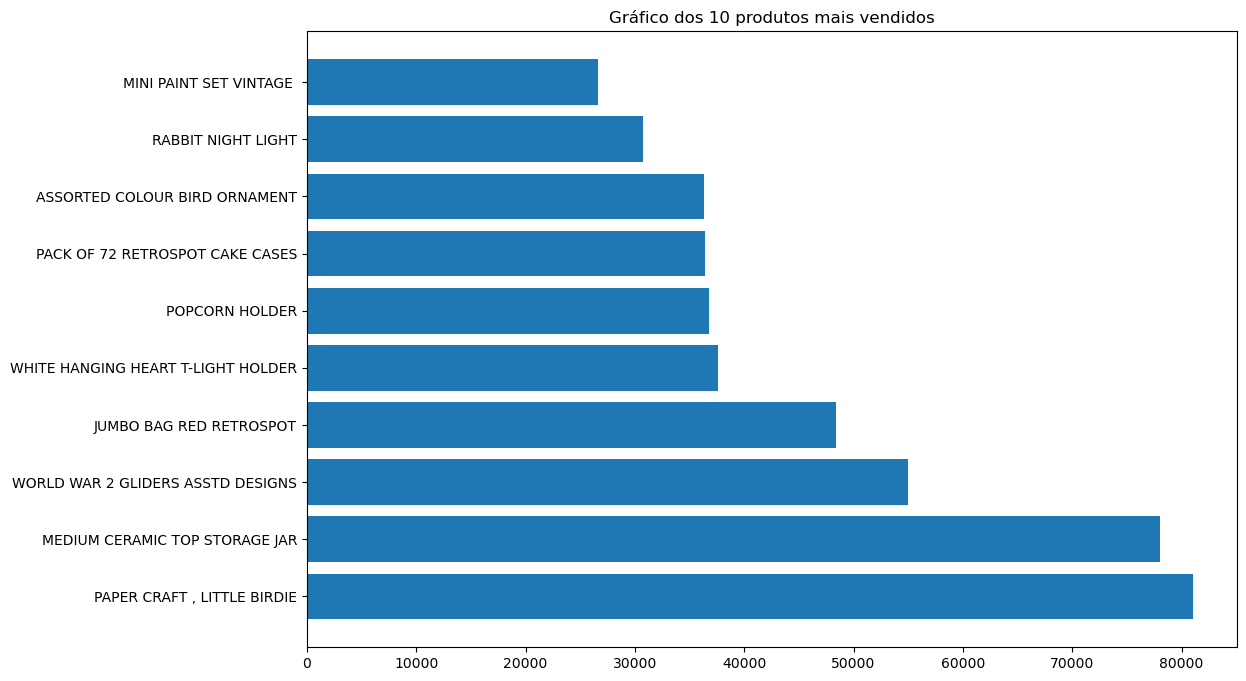

In [46]:
# Criando um DataFrame com os 10 produtos mais vendidos
top_products = ec_dt.groupby(['StockCode','Description'], as_index=False).agg(
    {'Quantity':'sum'}).sort_values(by='Quantity', ascending=False).head(10)

# Imprimindo a lista de produtos e sua quantidade de ve
print(top_products)

# Criando o gráfico
plt.figure(figsize=(12,8))
plt.barh(top_products['Description'], top_products['Quantity'])
plt.title('Gráfico dos 10 produtos mais vendidos')
plt.show()

Os dois produtos mais vendidos, com uma boa distância dos outros, são o **Paper Craft, Little Birdie** e **Medium Ceramic Top Storage Jar**, com 80995 e 78033 unidades vendidas, respectivamente. Em seguida temos **World War 2 Gliders Asstd Designs**, com 54951 unidades. Produtos tão diferentes entre os mais vendidos mostra como os consumidores da loja tem perfis variados.

## Análise de Recência, Frequência e Valor Monetário (RFM)

Este tipo de análise se baseia em três características dos consumidores para alocá-los em grupos. A primeira é a **recência**, ou seja, o quão recente foi a última compra do consumidor. A segunda é a **frequência**, que indica a frequência de compras do consumidor. Por fim, há o **valor monetário**, que se refere a quanto o consumidor gastou no período. Esses dados nos permitem classificar os consumidores em grupos mais específicos, o que pode ajudar a gerar campanhas de marketing direcionadas.

Vamos começar calculando a recência. Para isso, vamos descobrir, utilizando nossa tabela sem IDs de usuários vazios, o valor mais alto na coluna ``Week`` para cada consumidor. Isso vai nos informar a semana onde ocorreu a compra mais recente do usuário.

In [47]:
# Criando uma tabela com o ID de cada usuário e a semana de sua compra mais recente
recency = ec_dt_.groupby('CustomerID', as_index=False)['Week'].max()

# Renomeando as colunas
recency.columns = ['CustomerID', 'Recency']

# Juntando a informação com a tabela "ec_dt_"
ec_dt_ = ec_dt_.merge(recency, on='CustomerID', how='left')

# Vendo alguns dados sobre a distribuição
ec_dt_.groupby('CustomerID').agg({'Recency':'max'}).describe(datetime_is_numeric=True)

,Recency
count,4338
mean,2019-09-03 02:45:58.506224384
min,2018-11-29 00:00:00
25%,2019-07-18 00:00:00
50%,2019-10-17 00:00:00
75%,2019-11-14 00:00:00
max,2019-12-05 00:00:00


Agora que calculamos a semana da última compra de cada consumidor, vamos criar uma função para dar uma pontuação a cada um de acordo com a sua recência. Para isso, vamos utilizar dos marcos do três quartis e dar pontuações de 1 a 4, de modo que quanto maior a pontuação, mais recente foi a última compra. Depois, vamos aplicar essa função para criar a coluna ``RecencyScore``.

In [48]:
# Definindo o formato e criando variáveis do tipo DateTime com os quartis para utilizar na função
fmt = '%Y-%m-%d'
first_q = datetime.strptime('2019-07-18', fmt)
second_q = datetime.strptime('2019-10-17', fmt)
third_q = datetime.strptime('2019-11-14', fmt)

# Criando a função "recency_score" para calcular a pontuação de recência de cada usuário
def recency_score(x):
    if x <= first_q:
        return 1
    if x <= second_q:
        return 2
    if x <= third_q:
        return 3
    if x > third_q:
        return 4

# Aplicando a função a tabela
ec_dt_['RecencyScore'] = ec_dt_['Recency'].apply(recency_score)

Classificamos os usuários em relação a recência, agora vamos fazer o mesmo em relação a frequência. Para calcular vamos utilizar um processo parecido, mas agora contando a quantidade de compras para cada consumidor.

In [49]:
# Calculando a frequ~encia por usuário e armazenando na tabela "frequency"
frequency = ec_dt_.groupby('CustomerID', as_index=False).agg({'InvoiceNo':'nunique'})

# Renomeando as colunas
frequency.columns = ['CustomerID', 'Frequency']

# Adicionando os dados de frequência a tabela "ec_dt_"
ec_dt_ = ec_dt_.merge(frequency, on='CustomerID', how='left')

# Solicitando algumas informações sobre a distribuição da frequência
ec_dt_.groupby('CustomerID').agg({'Frequency':'max'}).describe()

,Frequency
count,4338.000000
mean,4.272015
std,7.697998
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,209.000000


Com as informações sobre a distribuição da frequência dos usuários, vamos criar 4 níveis, de 1 a 4, para classsificá-los. Assim como fizemos com a recência, vamos criar uma função e aplicá-la a tabela de dados, para criar a coluna ``FrequencyScore``.

In [50]:
# Criando a função para classificar os usuários de acordo com a frequência
def frequency_score(x):
    if x == 1:
        return 1
    if x <= 2:
        return 2
    if x <= 5:
        return 3
    if x > 5:
        return 4

# Aplicando a função para criar a coluna "FrequencyScore"
ec_dt_['FrequencyScore'] = ec_dt_['Frequency'].apply(frequency_score)

Agoira vamos fazer o mesmo para os valores monetários. Primeiro vamos criar uma tabela com o valor total dos gastos de cada consumidor e, em seguida, adicionar esse valor a nossa tabela.

In [51]:
# Calculando o gasto total por consumidor
monetary = ec_dt_.groupby('CustomerID', as_index=False).agg({'OrderValue':'sum'})

# Renomeando as colunas
monetary.columns = ['CustomerID', 'Monetary']

# Adicionando os valores a nossa tabela "ec_dt_"
ec_dt_ = ec_dt_.merge(monetary, on='CustomerID', how='left')

Agora vamos criar uma pontuação com base no valor monetário, utilizando como referência os valores que obtivemos na etapa de EDA para a distribuição de gastos dos consumidores.

In [52]:
# Criando a função "monetary_score" para classificar os compradores com base em seus gastos
def monetary_score(x):
    if x <= 306:
        return 1
    if x <= 668:
        return 2
    if x <= 1660:
        return 3
    if x > 1660:
        return 4

# Aplicando a função para criar a coluna "MonetaryScore"
ec_dt_['MonetaryScore'] = ec_dt_['Monetary'].apply(monetary_score)

Para criar uma pontuação RFM geral precisamos compilar esses três fatores. Vamos utilizar um método simples aqui: a média dos três scores individuais. Armazenaremos o valor na coluna ``RFMScore``.

In [53]:
# Calculando o RFMScore
ec_dt_['RFMScore'] = (ec_dt_['RecencyScore']+ec_dt_['FrequencyScore']+ec_dt_['MonetaryScore'])/3

# Imprimindo alguns valores da distribuição
ec_dt_.groupby('CustomerID').agg({'RFMScore':'max'}).describe()

,RFMScore
count,4338.000000
mean,2.424696
std,0.956850
min,1.000000
25%,1.666667
50%,2.333333
75%,3.333333
max,4.000000


Temos uma distribuição razoavelmente equilibrada entre os grupos. Vamos criar uma tabela com a quantidade de consumidores por pontuação e utilizar essa tabela para criar um gráfico de barras.

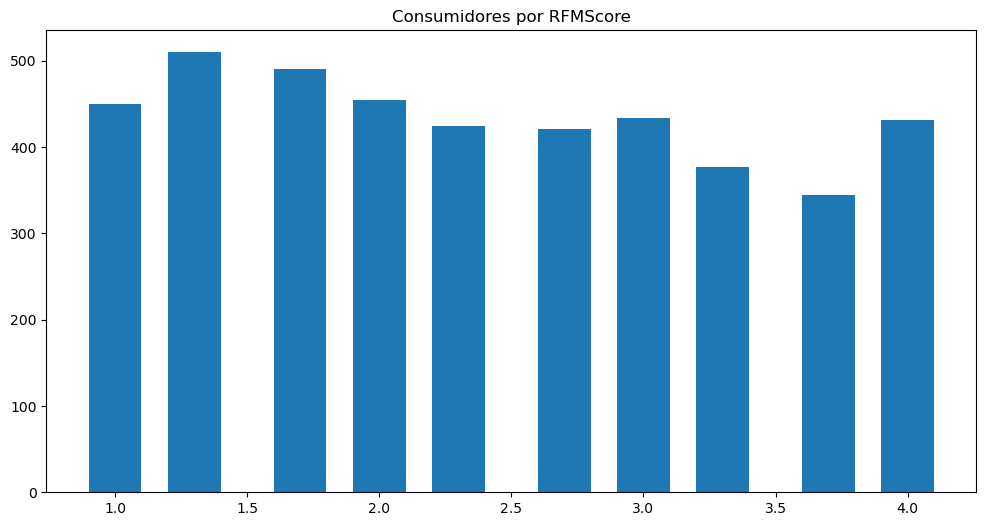

In [54]:
# Criando a tabela "customers_rfm"
customers_rfm = ec_dt_.groupby('RFMScore', as_index=False).agg({'CustomerID':'nunique'})

# Criando o gráfico e removendo algumas casas decimais para facilitar a visualização
plt.figure(figsize=(12,6))
plt.bar(x=customers_rfm['RFMScore'].round(1), height=customers_rfm['CustomerID'], width=0.2)
plt.title('Consumidores por RFMScore')
plt.show()

Podemos observar que há uma distribuição equilibrada entre os consumidores. Vamos ver exatamente quantos clientes existem em cada grupo:

In [55]:
customers_rfm.sort_values(by='CustomerID', ascending=False)

,RFMScore,CustomerID
1,1.333333,510
2,1.666667,491
3,2.000000,455
0,1.000000,450
6,3.000000,434
9,4.000000,432
4,2.333333,424
5,2.666667,421
7,3.333333,377
8,3.666667,344


Os grupos são bem equilibrados, com destaque para os níveis de 1 a 3 que parecem possuir mais usuários. Esses números porém são pouco expressivos. Para facilitar a análise vamos criar grupos com nomes mais simbólicos e segmentar os usuários com base em suas pontuações tanto no RFM total, quanto nas categorias de recência, frequência e valor monetário separadas. O primeiro grupo, dos melhores consumidores, chamaremos de **Top**: são usuários com pontuação de 4 no RFM (nesse caso, não é preciso considerar os pontos individuais). O segundo grupo será formado por consumidores com recência alta (4) e frequência baixa (igual ou menor que 2), sem considerar o valor monetário: essas características indicam novos usuários, e por isso os agruparemos em **New**. Consumidores com frequência média a alta (igual ou maior que 2), alta pontuação no valor monetário (acima de 3) e recência baixa (menor que 3) são usuários que compraram muito na loja, mas que estão sem comprar há um tempo, o que indica que são clientes que a loja pode perder, estarão na categoria **Risk**. Por fim, na categoria **Potential** estarão os consumidores com potencial de tornarem-se **Top**: gastaram muito ("m" >= 3) e tem frequência mediana (entre 2 e 3). Os consumidores que não se encaixarem em nenhum dessas categorias ficarão em **Other**.

Para segmentar os consumidores vamos criar uma função, ``rfm_group()``, e a aplicaremos a nossa tabela ``ec_dt_``.

In [56]:
# Criando a função
def rfm_group(rfm, r, f, m):
    if rfm == 4:
        return 'Top'
    if r == 4 and f <= 2:
        return 'New'
    if f >= 2 and m >= 3 and r < 3:
        return 'Risk'
    if 3 >= f >=2  and m >= 3:
        return 'Potential'
    else:
        return 'Other'
    
# Aplicando a tabela
ec_dt_['RFMGroup'] = ec_dt_.apply(lambda x: rfm_group(x['RFMScore'], x['RecencyScore'], x['FrequencyScore'], x['MonetaryScore']), axis=1)

Vamos criar uma tabela com a quantidade de usuários por grupo e exibir o resultado em um gráfico de barras, com diferentes cores para cada grupo:

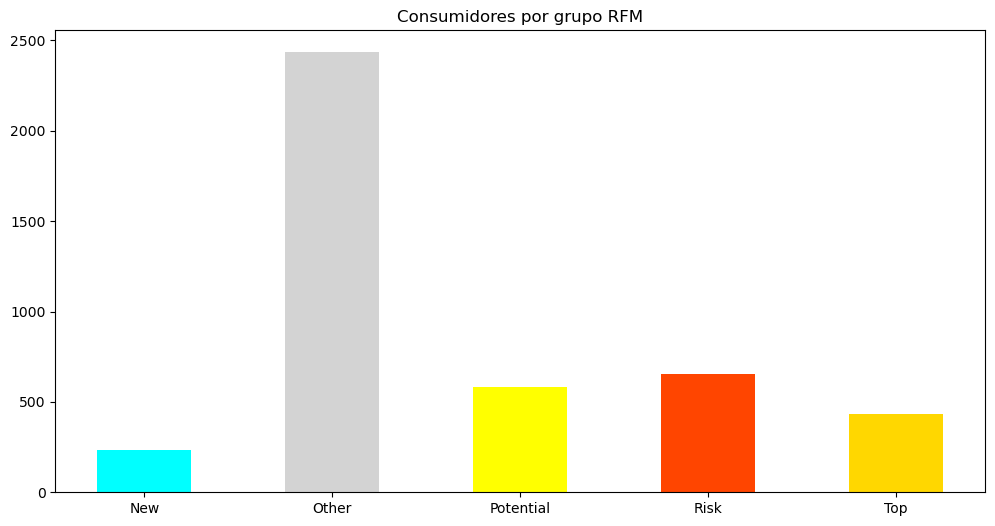

In [57]:
# Criando a tabela "groups" com a quantidade de consumidores por grupo
groups = ec_dt_.groupby('RFMGroup', as_index=False).agg({'CustomerID':'nunique'})

# Criando e exibindo o gráfico
rfm_colors = ['aqua', 'lightgray', 'yellow', 'orangered', 'gold']
plt.figure(figsize=(12,6))
plt.bar(x=groups['RFMGroup'], height=groups['CustomerID'], width=0.5, color=rfm_colors)
plt.title('Consumidores por grupo RFM')
plt.show()

O maior grupo é dos consumidores que não pertencem a nenhum grupo específico. Em seguida, porém, temos os consumidores em risco de perda, **Risk**. Há fatias semelhantes para consumidores **Top** e **Potential**, o que é um bom sinal, afinal são consumidores que gastam muito na loja. Por fim, há o grupo com os novos usuários.

Conhecer os usuários **Top** é interessante para entender melhor as características dos principais consumidores da loja e criar campanhas de marketing para atrair novos clientes baseando-se nesses traços. Já os usuários nos grupos **Risk** e **Potential** são importantes para ações de marketing específicas. Promoções como cupons de desconto e lembretes para comprar novamente produtos já adquiridos podem funcionar para trazer de volta consumidores em risco, e programas de pontos e outros métodos de fidelidade podem levar os consumidores com pontecial para o grupo de melhores consumidores.

Analisar os produtos mais consumidos pelos consumidores com potencial pode ser interessante para conhecer melhor o seu perfil. Vamos descobrir quais são os 10 produtos mais consumidos por esse grupo:

In [78]:
ec_dt_[(ec_dt_['RFMGroup']=='Potential')].groupby(['StockCode', 'Description']).agg(
    {'CustomerID':'nunique'}).sort_values(by='CustomerID', ascending=False).head(10)

,,CustomerID
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,145
85123A,WHITE HANGING HEART T-LIGHT HOLDER,136
22138,BAKING SET 9 PIECE RETROSPOT,128
22086,PAPER CHAIN KIT 50'S CHRISTMAS,125
23084,RABBIT NIGHT LIGHT,123
85099B,JUMBO BAG RED RETROSPOT,120
84879,ASSORTED COLOUR BIRD ORNAMENT,120
22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,111
21212,PACK OF 72 RETROSPOT CAKE CASES,111


**REGENCY CAKESTAND 3 TIER** está no topo da lista, seguido por **WHITE HANGING HEART T-LIGHT HOLDER** e **BAKING SET 9 PIECE RETROSPOT**, porém não há uma grande diferença entre os primeiros produtos da lista. Incluir alguns desses produtos em emails promocionais pode ser uma ação interessante para aumentar os pedidos desse grupo.

## Lifetime Value (LTV)

Agrupar clientes pelo período da primeira compra na loja e calcular quanto cada grupo rendeu em média é o que chama-se de "Lifetime value". Descobrir o LTV ajuda a compreender o valor mensal médio que cada consumidor rende a loja e torna possível comparar diferentes grupos, ou coortes, de acordo com o período da primeira compra.

Vamos começar criando uma tabela com o ID de cada consumidor e o mês da primeira compra.

In [58]:
# Criando a tabela "first_order"
first_order = ec_dt_.groupby('CustomerID').agg({'Month':'min'}).reset_index()

# Renomeando as colunas
first_order.columns = ['CustomerID', 'FirstOrderMonth']

# Imprimindo as primeiras linhas
first_order.head()

,CustomerID,FirstOrderMonth
0,12346.0,2019-01-01
1,12347.0,2018-12-01
2,12348.0,2018-12-01
3,12349.0,2019-11-01
4,12350.0,2019-01-01


Vamos calcular agora a quantidade de novos clientes por mês.

In [59]:
# Criando a tabela com o número de clientes por coorte
cohort_sizes = first_order.groupby('FirstOrderMonth').agg({'CustomerID':'nunique'}).reset_index()

# Renomeando as colunas
cohort_sizes.columns = ['FirstOrderMonth', 'NewCustomers']

# Imprimindo as primeiras linhas
cohort_sizes.head()

,FirstOrderMonth,NewCustomers
0,2018-11-01,188
1,2018-12-01,697
2,2019-01-01,472
3,2019-02-01,368
4,2019-03-01,425


Para construir as coortes para cada um dos meses precisamos unir as informações da tabela ``first_order`` com nossa tabela ``ec_dt_``.

In [60]:
# Criando a tabela "cohort_dt" com os dados de "ec_dt_" e "first_order"
cohort_dt = pd.merge(ec_dt_, first_order, on='CustomerID')

# Imprimindo as primeiras linhas
cohort_dt.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,OrderValue,Date,Week,...,Month,Recency,RecencyScore,Frequency,FrequencyScore,Monetary,MonetaryScore,RFMScore,RFMGroup,FirstOrderMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30,2018-11-29,2018-11-29,...,2018-11-01,2018-11-29,1,34,4,5391.21,4,3.0,Risk,2018-11-01
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,...,2018-11-01,2018-11-29,1,34,4,5391.21,4,3.0,Risk,2018-11-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00,2018-11-29,2018-11-29,...,2018-11-01,2018-11-29,1,34,4,5391.21,4,3.0,Risk,2018-11-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,...,2018-11-01,2018-11-29,1,34,4,5391.21,4,3.0,Risk,2018-11-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34,2018-11-29,2018-11-29,...,2018-11-01,2018-11-29,1,34,4,5391.21,4,3.0,Risk,2018-11-01


Agora vamos agrupar os dados pelo mês da primeira compra e pelo mês do pedido e somar a receita.

In [61]:
# Criando a tabela "cohorts"
cohorts = cohort_dt.groupby(['FirstOrderMonth', 'Month']).agg({'OrderValue':'sum'}).reset_index()

# Renomeando a tabela
cohorts.columns = ['FirstOrderMonth', 'Month', 'Revenue']

# Imprimindo as primeiras linhas
cohorts.head()

,FirstOrderMonth,Month,Revenue
0,2018-11-01,2018-11-01,93390.06
1,2018-11-01,2018-12-01,85374.84
2,2018-11-01,2019-01-01,70785.34
3,2018-11-01,2019-02-01,51493.64
4,2018-11-01,2019-03-01,77176.09


Aqui temos a receita total de cada coorte em cada mês. Vamos adicionar a essa tabela as informações da quantidade de novos compradores de cada coorte.

In [62]:
# Criando a tabela "report" juntando as tabelas "cohorts" e "cohort_sizes"
report = pd.merge(cohort_sizes, cohorts, on='FirstOrderMonth')

# Imprimindo as primeiras linhas
report.head()

,FirstOrderMonth,NewCustomers,Month,Revenue
0,2018-11-01,188,2018-11-01,93390.06
1,2018-11-01,188,2018-12-01,85374.84
2,2018-11-01,188,2019-01-01,70785.34
3,2018-11-01,188,2019-02-01,51493.64
4,2018-11-01,188,2019-03-01,77176.09


O ideal agora seria calcular o lucro de cada coorte, mas como não temos dados sobre os gastos da loja com marketing para cada período, vamos considerar apenas a receita. Para facilitar nossa análise, vamos criar um parâmetro de idade para as coortes, subtraindo o mês da primeira compra do mês atual para criar a coluna ``Age``.

In [63]:
# Criando a coluna "Age"
report['Age'] = (report['Month']-report['FirstOrderMonth'])/np.timedelta64(1, 'M')

# Arredondando os valores para valores inteiros
report['Age'] = report['Age'].round().astype('int')

# Imprimindo as primeiras linhas
report.head()

,FirstOrderMonth,NewCustomers,Month,Revenue,Age
0,2018-11-01,188,2018-11-01,93390.06,0
1,2018-11-01,188,2018-12-01,85374.84,1
2,2018-11-01,188,2019-01-01,70785.34,2
3,2018-11-01,188,2019-02-01,51493.64,3
4,2018-11-01,188,2019-03-01,77176.09,4


Com esses dados podemos calcular a LTV. Para isso, vamos dividir a receita de cada coorte pela quantidade de usuários de cada uma. Isso nos dará o LTV médio de cada coorte. Depois vamos utilizar os resultados para criar uma tabela dinâmica de modo que os dados fiquem mais claros.

In [64]:
# Criando a coluna "LTV" com o LTV médio por coorte
report['LTV'] = report['Revenue'] / report['NewCustomers']

# Criando a tabela dinâmica "output"
output = report.pivot_table(index='FirstOrderMonth', columns='Age', values='LTV', aggfunc='mean').round(1)

# Imprimindo a tabela
output

Age,0,1,2,3,4,5,6,7,8,9,10,11,12,13
FirstOrderMonth,,,,,,,,,,,,,,
2018-11-01,496.8,454.1,376.5,273.9,410.5,249.0,495.2,373.8,364.0,463.6,509.6,659.4,813.4,221.1
2018-12-01,561.9,323.4,254.7,313.6,215.5,372.6,331.3,348.2,398.9,485.1,513.9,533.9,144.3,NaN
2019-01-01,668.1,116.0,149.2,160.5,205.8,171.6,166.5,176.8,155.7,267.2,278.1,44.3,NaN,NaN
2019-02-01,438.0,75.1,95.7,129.4,97.0,98.8,124.6,156.3,142.5,174.1,14.7,NaN,NaN,NaN
2019-03-01,429.3,63.4,145.3,91.0,122.0,103.8,137.1,174.5,153.2,19.8,NaN,NaN,NaN,NaN
2019-04-01,402.6,89.2,78.2,73.3,75.4,93.8,97.6,110.2,14.0,NaN,NaN,NaN,NaN,NaN
2019-05-01,434.0,64.8,71.2,62.5,97.4,119.6,137.4,584.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-01,566.9,69.4,56.5,127.1,113.7,172.5,19.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,447.0,58.3,83.2,95.5,101.9,24.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Na tabela, os valores vazios apontam idades que as coortes ainda não atingiram. Somando as linhas, podemos calcular o LTV de cada coorte especificamente. Vamos criar um mapa de calor para nos ajudar a visualizar possíveis diferenças entre as coortes.

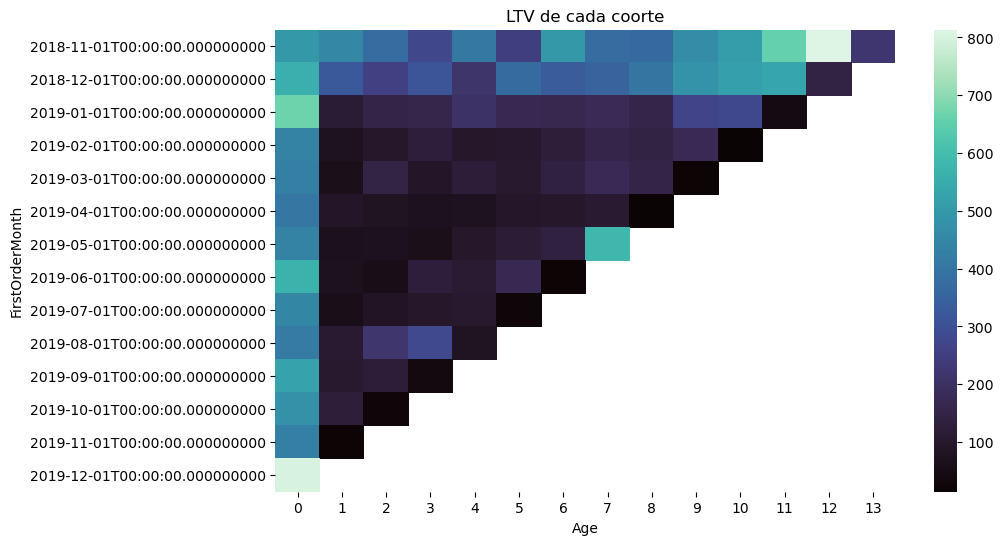

In [65]:
plt.figure(figsize=(10,6))
sns.heatmap(output, cmap='mako')
plt.title('LTV de cada coorte')
plt.show()

A coorte mais antiga aparenta ter o LTV mais alto, seguida pela segunda. A partir da coorte do mês 3 é visível uma diminuição no LTV. Isso pode ser devido a mudanças nas estratégias de marketing da loja que não renderam resultados tão positivos.

Realmente a primeira e a segunda coorte parecem ter algo de especial em relação as demais, mesmo considerando as idades. Essas informações são interessantes para o departamento de marketing, uma vez que é possível que hajam semelhanças entre os processos de aquisição de consumidores nas campanhas implementadas nos meses com coortes que geraram mais renda. Dados sobre os gastos mensais para aquisição de novos clientes poderiam incrementar ainda mais a análise.

Vamos utilizar a segmentação de clientes que criamos a partir da análise RFM e observar a proporção de cada grupo nas coortes de mais sucesso.

In [66]:
# Criando uma tabela com o número de consumidores por coorte e por grupo
cohort_rfm = cohort_dt.groupby(['FirstOrderMonth', 'RFMGroup'], as_index=False).agg({'CustomerID':'nunique'})

# Adicionando a informação sobre o número de consumidores ded cada coorte
cohort_rfm = cohort_rfm.merge(cohort_sizes, on='FirstOrderMonth', how='left')

# Renomeando as colunas
cohort_rfm.columns = ['FirstOrderMonth', 'RFMGroup', 'Customers', 'CohortCustomers']

# Calculando a proporção de cada grupo RFM em cada coorte
cohort_rfm['RFMProportion'] = (cohort_rfm['Customers']/cohort_rfm['CohortCustomers'])*100

# Deixando as penas as colunas que interessam para a análise
cohort_rfm.drop('CohortCustomers', axis=1, inplace=True)

# Imprimindo a proporção da primeira coorte
cohort_rfm.loc[cohort_rfm['FirstOrderMonth']=='2018-11-01']

,FirstOrderMonth,RFMGroup,Customers,RFMProportion
0,2018-11-01,New,3,1.595745
1,2018-11-01,Other,84,44.680851
2,2018-11-01,Potential,16,8.510638
3,2018-11-01,Risk,33,17.553191
4,2018-11-01,Top,52,27.659574


Há uma boa proporção de clientes **Top** e **Risk** na primeira coorte, mas também muitos não classificados. Vamos comparar com a coorte número 6, que parece ter um resultado especialmente ruim.

In [67]:
cohort_rfm.loc[cohort_rfm['FirstOrderMonth']=='2019-04-01']

,FirstOrderMonth,RFMGroup,Customers,RFMProportion
25,2019-04-01,New,6,2.083333
26,2019-04-01,Other,160,55.555556
27,2019-04-01,Potential,50,17.361111
28,2019-04-01,Risk,65,22.569444
29,2019-04-01,Top,7,2.430556


Essa coorte possui bem menos clientes do tipo **Top** e muitos mais clientes dos grupos **Potential** e **Risk**. Essa diferença na distribuição pode ser um dos motivos do desempenho inferior da coorte. Vamos ver como cada é o LTV de cada grupo RFM.

In [68]:
# Adicionando a informação do LTV na tabela "cohort_rfm"
cohort_rfm = cohort_rfm.merge(report, on='FirstOrderMonth', how='left')

# Criando a tabela "rfm_ltv" com os valores médios do LTV agrupados por grupo RFM
rfm_ltv = cohort_rfm.groupby('RFMGroup', as_index=False).agg({'LTV':'mean'}).sort_values(by='LTV', ascending=False)

# Imprimindo a tabela
rfm_ltv

,RFMGroup,LTV
0,New,236.290677
2,Potential,236.290677
3,Risk,230.984253
4,Top,230.984253
1,Other,230.840193


Apesar do que seria previsível, o grupo **Top** ficou apenas em teceiro lugar, empatado com o grupo **Risk**. Já os grupos **New** e **Potential** empataram em primeiro. As diferenças, porém, não foram tão significativas. Isso pode sinalizar que, a longo prazo, os grupos tendem a ter rendimentos parecidos.

## Market Basket Analysis: análise de cestas de compras

É comum que produtos sejam adquiridos em conjuntos. Alguns produtos são comprados em conjunto com outros de forma mais frequente, de modo que é possível afirmar que, para os compradores, existem associações entre os itens. A técnica Market Basket Analysis é utilizada por grandes lojas para descobrir quais produtos são mais frequentemente comprados em conjunto, ou seja, quais itens são relacionados entre si pelos consumidores.

Para esta análise, vamos utilizar os módulos *Apriori* e *Association Rules* da biblioteca *mlxtend*. Para começar, vamos criar um DataFrame com as quantidades dos produtos compradas agrupadas pelo número do invoice e pela descrição. Essa tabela terá como colunas o nome dos produtos e como índice o número dos invoices. Seus valores serão a quantidade do item que foi adquirido naquele pedido e 0 quando o produto não consta no pedido. Como essa análise não involve os consumidores individualmente, vamos utilizar nossa tabela que inclui as linhas sem ``CustomerID``.

In [69]:
# Criando a tabela agrupada
basket = ec_dt.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# Imprimindo as primeiras linhas
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Olhando os valores das 5 primeiras linhas parece que há apenas zeros, mas como vemos no rodapé da imagem existem 4026 colunas. Esse é o número de produtos incluídos em nossos dados, logo se fôssemos ver toda a tabela, com certeza encontraríamos valores para vários produtos adquiridos.

Agora, precisamos modificar nossa tabela, para que ela possua apenas valores booleanos, ou seja, 0 (False) quando o produto não foi adquirido no pedido e 1 (True) quando foi, independente da quantidade. Para isso, vamos criar a função ``zero_one()`` e aplicar aos valores da nossa tabela com o método ``applymap()``.

In [70]:
# Criando a função "zero_one"
def zero_one(x):
    if x <= 0:
        return False
    if x >= 1:
        return True

# Aplicando a função para criar a tabela basket_enc
basket_enc = basket.applymap(zero_one)

# Exibindo a nova tabela
basket_enc

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581584,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581585,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
581586,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Semelhante a tabela anterior, porém os valores 0.0 foram substituídos por False. Os valores acima de 1 agora são True. Como pedidos com apenas 1 item não são relevantes para nossa análise, vamos filtrar nosso DataFrame para retirar esses pedidos.

In [71]:
# Filtrando o pedidos com apenas 1 item
basket_filtered = basket_enc[(basket_enc > 0).sum(axis=1) >=2]

# Exibindo a tabela
basket_filtered

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536370,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581584,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581585,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


Diminuímos 1641 linhas da tabela (8,2% dos dados), esses eram pedidos com menos de 2 itens.

Agora vamos aplicar o algorítmo *Apriori* para encontrar os produtos que mais aparecem na nossa tabela. Utilizaremos um suporte mínimo de 3%, para excluir da nossa tabela itens com frequência muito baixa, uma vez que esses produtos não são tão interessantes para nossa análise.

In [72]:
# Criando a tabela "frequent_sets" com os itens mais frequentes, ordenados pelo nível de suporte
frequent_itens = apriori(basket_filtered, min_support=0.03, use_colnames=True).sort_values('support', ascending=False)

# Exibindo os 10 primeiros itens da tabela
frequent_itens.head(10)

,support,itemsets
145,0.122114,(WHITE HANGING HEART T-LIGHT HOLDER)
61,0.113270,(JUMBO BAG RED RETROSPOT)
115,0.107320,(REGENCY CAKESTAND 3 TIER)
96,0.091162,(PARTY BUNTING)
79,0.085321,(LUNCH BAG RED RETROSPOT)
9,0.079317,(ASSORTED COLOUR BIRD ORNAMENT)
126,0.075113,(SET OF 3 CAKE TINS PANTRY DESIGN )
90,0.072056,(PACK OF 72 RETROSPOT CAKE CASES)
73,0.069382,(LUNCH BAG BLACK SKULL.)
86,0.068126,(NATURAL SLATE HEART CHALKBOARD )


Temos que **WHITE HANGING HEART T-LIGHT HOLDER** é o item que mais aparece, com frequência de 0.1221, o que significa que o item aparece em 12,21% dos pedidos na tabela. Em seguida há **JUMBO BAG RED RETROSPOT**, adquirida em 11,33% dos pedidos e **REGENCY CAKESTAND 3 TIER** com frequência de 10,73%.

Agora podemos utilizar esses dados para calcular os produtos mais associados nos pedidos, utilizando o algoritmo *association_rules*. O resultado nos apontará os itens que mais são adquiridos em conjunto.

In [73]:
# Criando a tabela "rules" com as associações entre produtos
rules = association_rules(frequent_itens, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)

# Imprimindo a tabela
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.055298,0.041487,0.034500,0.623889,15.038198,0.032206,2.548487
1,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.041487,0.055298,0.034500,0.831579,15.038198,0.032206,5.609169
2,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.041487,0.057973,0.032644,0.786842,13.572656,0.030239,4.419388
3,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.057973,0.041487,0.032644,0.563089,13.572656,0.030239,2.193838
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.055298,0.057973,0.041869,0.757157,13.060601,0.038663,3.879162
5,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.057973,0.055298,0.041869,0.722222,13.060601,0.038663,3.400928
6,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.057318,0.053223,0.034936,0.609524,11.452171,0.031886,2.424672
7,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.053223,0.057318,0.034936,0.656410,11.452171,0.031886,2.743628
8,(PAPER CHAIN KIT VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.044544,0.062940,0.030133,0.676471,10.747844,0.027329,2.896367
9,(PAPER CHAIN KIT 50'S CHRISTMAS ),(PAPER CHAIN KIT VINTAGE CHRISTMAS),0.062940,0.044544,0.030133,0.478751,10.747844,0.027329,1.833013


O algoritmo identificou 30 pares de produtos com associação, mas como cada conjunto aparece duas vezes, temos então 15 pares. Um valor importante que temos a considerar é o *lift*, ele indica a frequência de ocorrência entre dois objetos, comparada ao valor obtido pela aplicação de um modelo estatístico de independência, e pode variar entre 0 e infinito. O valor de 1 indica que a ocorrência da associação é igual a prevista no modelo de independência, portanto não é estatisticamente relevante. Valores menores que 1, indicam um efeito negativo entre o aparecimento do primeiro objeto e o aparecimento do segundo. E um valor de *lift* acima de 1 indica os objetos aparecem mais frequentemente juntos do que previsto pelo modelo de independência, o que demonstra um efeito positivo entre o primeiro e o segundo item.

Analisando o valor de *lift* dos itens, o conjunto **GREEN REGENCY TEACUP AND SAUCER**+**PINK REGENCY TEACUP AND SAUCER** é o que mais aparece junto, com um *lift* de 15,038. O suporte do conjunto, 0,0345, indica que os produtos foram comprados juntos em 3,34% das vendas da nossa tabela. **PINK REGENCY TEACUP AND SAUCER+ROSES REGENCY TEACUP AND SAUCER** é o segundo par de produtos mais combinados, com *lift* de 13,573, e suporte de 0,0326 (3,26%). Em terceiro lugar, temos **GREEN REGENCY TEACUP AND SAUCER+ROSES REGENCY TEACUP AND SAUCER**, *lift* de 13,061 e suporte de 0,0419 (4,19%). Esses três conjunto demonstram relações entre pares de chícaras e pires de certas cores. Semelhante a esses conjuntos temos pares de despertadores, kits de papéis e mochilas.

Esses dados tem muito potencial para sistemas de recomendação, *cross-selling* e criação de kits em ofertas.

## Testando hipóteses

Segmentamos os clientes em vários grupos de acordo com sua pontuação RFM. Um grupo em especial classificamos como sendo dos melhores clientes. Porém, não sabemos se a receita desse grupo é, em média, superior aos outros. Essa informação pode nos ajudar na decisão sobre os gastos de marketing para trazer consumidores dos outros grupos para o grupo **Top**.

Um teste estatístico pode nos ajudar a descobrir se há alguma diferença entre essas médias. Para comparar médias de duas amostras, utilizamos o teste T: ele calcula a probabilidade de encontrarmos essa diferença entre médias de populações idênticas. Primeiro, vamos definir nossas hipóteses. A nossa hipótese é de que a receita média do grupo **Top** é maior que a receita média de todos os consumidores. Logo, a hipótese nula no nosso teste, que rejeitaremos caso o teste seja bem sucedido, será: "A receita média do grupo **Top** é menor ou igual a receita média de todos os usuários". Já a hipótese alternativa é de que a receita média do grupo é maior que a de todos os usuários.
Vamos estabelecer nosso valor *alfa*. Esse é o valor máximo que o valor P, calculado pelo teste, pode atingir para que rejeitemos nossa hipótese nula. Como é costume, utilizaremos um valor de 5% para *alfa*.
Como nosso interesse é saber se a média do grupo é maior que a média da população, utilizaremos um teste unicaudal, o que significa que testaremos apenas para a possibilidade da média ser maior. O teste não estimará se a média dos grupos é diferente, mas calculará a significância estatística da média do primeiro grupo ser maior que a do segundo.

In [74]:
# Criando as tabelas com a receita do grupo Top e com a receita de todos os consumidores
top_group =  ec_dt_[(ec_dt_['RFMGroup']=='Top')]['OrderValue'].reset_index(drop=True)
total_value = ec_dt_['OrderValue']

# Executando o teste
print('P-value: {0:.10f}'.format(st.ttest_ind(top_group, total_value, alternative='greater').pvalue))

P-value: 0.0000000013


Como nosso valor P foi menor que *alfa*, nós podemos rejeitar a hipótese nula. Ou seja, é estatísticamente improvável que a média de receita do grupo **Top** seja igual ou menor que a média dos consumidores como um todo, com significância de 5%. Assim, implementar ações de marketing para converter usuários para o grupo **Top** parece ser uma decisão válida.

## Conclusões

Em nossa análise, observamos os seguintes pontos:

* Há muita variância nos dados, como gastos e pedidos por usuário, quantidade de produtos e valor dos pedidos
    * Isso demonstra que há muitas possibilidades para segmentações de clientes e produtos
* O período entre Setembro e Dezembro parece ser o mais movimentado na loja, com maior número de pedidos e consumidores
    * Informação que é interessante para planejamento de campanhas de marketing e promoções
* A maioria dos pedidos ocorre entre 9h e 16h
* Segmentando os consumidores de acordo com sua recência, frequência e valor monetário (RFM) descobrimos que grande parte são clientes com bom potential ou que bons compradores que não voltam a loja há algum tempo
    * Nosso teste de hipóteses apontou que há significância na diferença entre a receita média do grupo Top e dos demais consumidores: o grupo dos melhores consumidores realmente tem receitas médias superiores; esse resultado reforça a validade de esforços de marketing para trazer consumidores para esse grupo em especial
* Na análise de Lifetime Value (LTV) descobrimos que consumidores que fizeram sua primeira compra no mês 11-2018 e no mês 12-2018 tiveram desempenho melhor do que consumidores posteriores
    * Investigar as ações de marketing que atraíram esses usuários pode trazer insights significativos para campanhas futuras
    * Considerando o grupos RFM, porém, não houve vantagem no LTV para o grupo Top em comparação aos demais, o que pode sugerir que a longo prazo, os grupos tenham rendimentos semelhantes
* Através da Market Basket Analysis identificamos vários produtos que são adquiridos frequentemente em conjunto, como xícaras, certos tipos de papéis, despertadores e mochilas
    * Essas informações são úteis para aplicação no sistema de recomendação da loja, assim como em ações de *cross-selling* e vendas em conjunto

Confira aqui uma apresentação resumida sobre as descobertas da análise: https://drive.google.com/file/d/1s1HMWbo4Wa5F9oC8a9WhLHLVz749U35S/view?usp=sharing

Aqui há um dashboard no Tableau explorando os dados: https://public.tableau.com/views/dashboard_ecommerce/Painel1?:language=pt-BR&publish=yes&:display_count=n&:origin=viz_share_link

### Referências

<https://clevertap.com/blog/rfm-analysis/> Método descritivo de como realizar uma análise RFM.

<https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis> Explicação teórica sobre utilização da análise RFM.


<https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce> Introdução ao modelo de Market Basket Analysis.

<https://deepnote.com/@code-along-tutorials/Market-Basket-Analysis-in-Python-An-Implementation-with-Online-Retail-Data-6231620b-cba3-4935-bde8-8ce1490868bf> Demonstração de como realizar uma análise de cesta de mercado em Python.

<https://www.ibm.com/docs/en/db2/11.1?topic=SSEPGG_11.1.0/com.ibm.im.model.doc/c_lift_in_an_association_rule.htm> Explicação de como interpretar o valor de *lift* na regra da associação em Market Basket Analyis.